# Locally-Linear Deep Learner on Tox21 dataset 
This set of experiments include Batch Normalization and Similarity Batching

In [19]:
%env TMPDIR=/tmp/temp 
#For joblib multi-threading

import os, sys
code_folder=os.path.join(os.getcwd(), "..", "..", "0_code")
sys.path.append(code_folder)

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])

import time

env: TMPDIR=/tmp/temp


# Data processing (If re-running code, skip to load data)

In [2]:
# Load Tox21 data
import pandas as pd
import numpy as np
dataset_name="XY_Tox21_CDKPaDEL_processed.csv"
df=pd.read_csv(os.path.join("..", 
                            "..",
                            "rawdata", 
                            dataset_name))

label_columns=range(5,17) #12 Tox21 labels
data_columns=range(17,1504) #1487 CDK+PaDEL descriptors (after filtering)
id_columns=range(5)  

training_ind=np.where(np.isin(df['Type'], ['Training', 'Testing']))[0]
testing_ind=np.where(df['Type']=="Score")[0]
print(f"{dataset_name} has data type 'Training', 'Testing' and 'Score'. Training and Testing (leaderboard) data are reflected in train while Score (Final Evaluation) data is in test.")

X_train=df.iloc[training_ind, data_columns].values
X_test=df.iloc[testing_ind, data_columns].values
y_train=df.iloc[training_ind, label_columns]
y_test=df.iloc[testing_ind, label_columns]
train_id_df=df.iloc[training_ind, id_columns]
test_id_df=df.iloc[testing_ind, id_columns]



XY_Tox21_CDKPaDEL_processed.csv has data type 'Training', 'Testing' and 'Score'. Training and Testing (leaderboard) data are reflected in train while Score (Final Evaluation) data is in test.


In [ ]:
#Load tanimoto similarity

dataset_sim_name="XY_Tox21_CDKPaDEL_processed_tanimoto.csv"
df_sim=pd.read_csv(os.path.join("..", 
                                "..",
                                "rawdata", 
                                dataset_sim_name
                               ), 
                   index_col=0
                  )

sim_train_df=df_sim.iloc[training_ind, training_ind+len(id_columns)]
sim_test_df=df_sim.iloc[testing_ind, training_ind+len(id_columns)]

## Impute missing values (as most ML can't deal with missing feature values)
Retain features with only 1 missing value. Drop features with only 1 unique value. Do median imputation. 

In [ ]:
def median_imputation(X_train, X_test):
    for col in range(len(X_train[0])):
        med=np.nanmedian(X_train[:,col])
        
        train_nanind=np.where(np.isnan(X_train[:,col]))[0]
        test_nanind=np.where(np.isnan(X_test[:,col]))[0]
        
        if len(train_nanind)>0:
            X_train[train_nanind,col]=med
        if len(test_nanind)>0:
            X_test[test_nanind,col]=med
    return X_train, X_test

def zero_imputation(y):
    for col in range(len(y[0])):
        nan_ind=np.where(np.isnan(y[:,col]))[0]
        if len(nan_ind)>0:
            y[nan_ind,col]=0
    return y
        

In [ ]:
retain_feat_ind=np.where(np.sum(np.isnan(X_train),axis=0)<2)[0]

X_train, X_test=median_imputation(X_train[:, retain_feat_ind], X_test[:, retain_feat_ind])



In [ ]:
# y_train_impute=zero_imputation(y_train.values)
# y_test_impute=zero_imputation(y_test.values)

## Check for feature correlations

In [ ]:
#Remove features that are almost identical to each other (R>0.95)
from scipy.stats import pearsonr
from itertools import combinations
m=X_train.shape[1]
R_mat=np.empty((m,m))
for (i,j) in combinations(range(m), 2):
    r=pearsonr(X_train[:,i], X_train[:,j])
    R_mat[i,j]=r[0]
    R_mat[j,i]=r[0]
for i in range(m):
    R_mat[i,i]=0.    
    
import seaborn as sns
ax= sns.heatmap(R_mat, center=0, cmap='bwr')

In [ ]:
R_mat=np.nan_to_num(R_mat, nan=1.)

arr=pd.Series(np.abs(R_mat.flatten()))

print(f"{np.count_nonzero(arr==1)} comparisons with R=1.00")
print(f"{np.count_nonzero(arr>0.95)} comparisons with R>0.95")

In [ ]:
# arr=np.where(R_mat==1.)

def split_ind(arr):
    # Given 2D array of pairs of indices, return the lowest index of connected groups of indices
    retain_list=[]
    omit_list=[]
    for i in range(len(arr[0])):
        head, tail=arr[0][i], arr[1][i]
        if head in retain_list:
            omit_list=np.append(omit_list,tail)
        elif tail in retain_list:
            omit_list=np.append(omit_list,head)
        else:
            retain_list=np.append(retain_list, head)
            omit_list=np.append(omit_list,tail)
        retain_list=np.setdiff1d(retain_list, omit_list)
        omit_list=np.unique(omit_list)
    return retain_list, omit_list
    

In [ ]:
retain_list2, omit_list2=split_ind(np.where(np.abs(R_mat)>0.99))

In [ ]:
len(omit_list2)

We omit comparisons with R>0.95

In [ ]:
filtered_features=np.setdiff1d(range(m), omit_list2)
X_train_filtered=X_train[:,filtered_features]
X_test_filtered=X_test[:,filtered_features]

print(f"{len(filtered_features)} out of {m} features retained.")

## Learn Fweights (by fitting COSA model)

In [ ]:
from algorithms import COSA
from importlib import reload
reload(COSA)
cosa_mdl=COSA.NNCosa(Fweight_init="uniform", lam=0.2, n_iter=100,
                                distance_measure="inv_exp_dist",
                     calc_D_ijk=False, threads=-1
                    )
cosa_mdl.fit(X_train_filtered)

In [ ]:
cosa_mdl.fit_OOS(X_test_filtered)

In [ ]:
# Fweights=cosa_mdl.output_Fweight()
# cosa_dist=cosa_mdl.output_Dmat()

## Save processed data

In [ ]:
save_folder=os.path.join("processed_data"
                        )
new_data_columns=np.array(data_columns)[filtered_features]

processed_df_columns=np.concatenate([id_columns, 
                                     label_columns, 
                                     new_data_columns
                                    ])
processed_df=df
processed_df.iloc[training_ind, new_data_columns]=X_train_filtered
processed_df.iloc[testing_ind, new_data_columns]=X_test_filtered
processed_df=processed_df.iloc[:, processed_df_columns]

processed_df.to_csv(os.path.join(
    save_folder,
    "XY_Tox21_CDKPaDEL_processedFiltered.csv"
))

In [ ]:
# # Save Fweights
import pandas as pd
Fweights=cosa_mdl.output_Fweight()
df= pd.DataFrame(Fweights)
df.to_csv(os.path.join(save_folder,
                       "Tox21_CDKPaDEL_Fweights_train.csv"), 
          index=False)

# import pandas as pd
# Fweights=pd.read_csv("Tox21_Fweights_train.txt")
# cosa_mdl.Fweight=Fweights.values

cosa_dist=cosa_mdl.output_Dmat()
df=pd.DataFrame(cosa_dist)
df.to_csv(os.path.join(save_folder,
                       "Tox21_CDKPaDEL_cosa_dist_train.csv"),
          index=False)

In [ ]:
Fweights_OOS=cosa_mdl.output_Fweight(OOS=True)
df= pd.DataFrame(Fweights_OOS)
df.to_csv(os.path.join(save_folder,
                       "Tox21_CDKPaDEL_Fweights_test.csv"), 
          index=False)

cosa_dist_OOS=cosa_mdl.output_Dmat(OOS=True)
df=pd.DataFrame(cosa_dist_OOS)
df.to_csv(os.path.join(save_folder,
                       "Tox21_CDKPaDEL_cosa_dist_test.csv"),
          index=False)

# Load processed data 
To be updated again when COSA fitting is completed

In [20]:
load_folder=os.path.join("processed_data"
                        )
dataset_name="XY_Tox21_CDKPaDEL_processedFiltered.csv"
load_df=pd.read_csv(os.path.join(load_folder, 
                                 dataset_name
                                ), 
                    index_col=0
                   )

label_columns=range(5,17) #12 Tox21 labels
data_columns=range(17,load_df.shape[1]) #945/1487 filtered CDK+PaDEL descriptors (after filtering)
id_columns=range(5)  

training_ind=np.where(np.isin(load_df['Type'], ['Training', 'Testing']))[0]
testing_ind=np.where(load_df['Type']=="Score")[0]
print(f"{dataset_name} has data type 'Training', 'Testing' and 'Score'. Training and Testing (leaderboard) data are reflected in train while Score (Final Evaluation) data is in test.")

X_train=load_df.iloc[training_ind, data_columns].values
X_test=load_df.iloc[testing_ind, data_columns].values
y_train=load_df.iloc[training_ind, label_columns]
y_test=load_df.iloc[testing_ind, label_columns]
train_id_df=load_df.iloc[training_ind, id_columns]
test_id_df=load_df.iloc[testing_ind, id_columns]


Fweights_df=pd.read_csv(os.path.join(load_folder, 
                                     "Tox21_CDKPaDEL_Fweights_train.csv"
                                    ))
Fweights_train=Fweights_df[load_df.columns[data_columns]].values

Fweights_OOS_df=pd.read_csv(os.path.join(load_folder,
                                          "Tox21_CDKPaDEL_Fweights_test.csv"
                                         ))
Fweights_test=Fweights_OOS_df[load_df.columns[data_columns]].values

XY_Tox21_CDKPaDEL_processedFiltered.csv has data type 'Training', 'Testing' and 'Score'. Training and Testing (leaderboard) data are reflected in train while Score (Final Evaluation) data is in test.


In [21]:
all_train_features = X_train
all_train_targets = y_train.values
test_features = X_test
test_targets = y_test.values
all_train_Fweights = Fweights_train
test_Fweights = Fweights_test

labels = load_df.columns[label_columns].values

## Calculate feature importance

In [ ]:
# Downselect features

from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel

# Feature selection
supports = []
for label_idx in range(len(labels)):
    valid_ind = ~np.isnan(all_train_targets[:, label_idx])
    clf = ExtraTreesRegressor(n_estimators=499, random_state=123)
    clf.fit(all_train_features[valid_ind], 
            all_train_targets[valid_ind, label_idx]
           )
    model = SelectFromModel(clf, prefit=True)
    supports.append(model.get_support())

selected_feat_ind = np.all(supports, axis=0)
print(f"{np.count_nonzero(selected_feat_ind)} features selected out of {all_train_features.shape[1]}")

selected_train_features = all_train_features[:, selected_feat_ind]
selected_test_features = test_features[:, selected_feat_ind]

Too few features selected if we require features to be important to ALL 12 labels. 

Text(0, 0.5, 'Number of features')

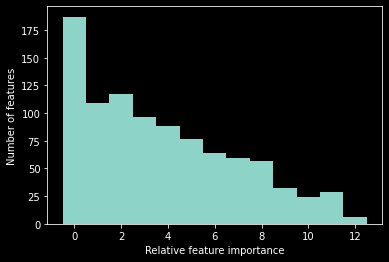

In [103]:
import matplotlib.pyplot as plt

feat_imp_ = np.sum(supports, axis=0)
plt.hist(feat_imp_, np.array(list(range(14)))-0.5)
plt.xlabel("Relative feature importance")
plt.ylabel("Number of features")

The distribution of "Important features" across each label is not uniform. Some features are important to all labels, while other features are important to only a few. 

Text(0, 0.5, 'Number of features')

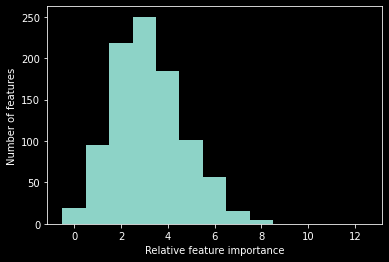

In [104]:
n_sel_feat = np.sum(supports, axis = 1)
random_feats = []
for n_ in n_sel_feat:
    random_feats.append(np.random.choice(range(len(supports[0])), 
                                         size = n_))

rand_freq = np.sum([np.isin(range(len(supports[0])), 
                            random_feats[i]) for i in range(12)], 
                   axis =0)
plt.hist(rand_freq, np.array(list(range(14)))-0.5 )
plt.xlabel("Relative feature importance")
plt.ylabel("Number of features")

If each label had a random set of important features, we would end up with a different distribution (as above). Suggest to cut-off at relative feature importance of 5, where a feature is less likely to be relatively 'important' purely by chance.

## Feature selection

In [6]:
feat_imp_ = np.sum(supports, axis=0)
selected_feat_ind = feat_imp_>4
print(f"{np.count_nonzero(selected_feat_ind)} features selected out of {all_train_features.shape[1]}")

selected_train_features = all_train_features[:, selected_feat_ind]
selected_test_features = test_features[:, selected_feat_ind]

348 features selected out of 945


In [8]:
import dill as pickle
with open("selected_feat_ind.ob", 'wb') as f:
    pickle.dump(selected_feat_ind, f)

## Load selected features

In [4]:
import dill as pickle
with open("selected_feat_ind.ob", 'rb') as f:
    selected_feat_ind = pickle.load(f)
    
print(f"{np.count_nonzero(selected_feat_ind)} features selected out of {all_train_features.shape[1]}")

selected_train_features = all_train_features[:, selected_feat_ind]
selected_test_features = test_features[:, selected_feat_ind]    
selected_train_Fweights = Fweights_train[:, selected_feat_ind]
selected_test_Fweights = Fweights_test[:, selected_feat_ind]

348 features selected out of 945


# Train Locality-Sensitive Deep Learner

In [8]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.keras.backend.set_floatx('float32')    

from tf_helpers import get_weights_dicts, BinaryCrossEntropyIgnoreNan
from tf_helpers import SimilarityBatchingDataset
from tf_helpers import AveragedAUCIgnoreNan

In [9]:
import time
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from algorithms import attention_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler


def get_attentionwFW_model(n_attention,
                           n_attention_hidden,
                           n_feat,
                           n_out,
                           n_concat_hidden,
                           concat_activation,
                           n_attention_out,
                           kernel_initializer,
                           bias_initializer,
                           attention_hidden_activation,
                           attention_output_activation,
                           n_hidden,
                           hidden_activation,
                           kernel_regularizer,
                           bias_regularizer,
                           random_seed=123
                           ):
    input_shape = (n_feat*2,)
    input_layer = Input(shape=input_shape)
    tf.random.set_seed(random_seed)
    attentions_layer = attention_model.ConcatAttentionswFeatWeights(
        n_attention=n_attention,
        n_attention_hidden=n_attention_hidden,
        n_attention_out=n_attention_out,
        n_feat=n_feat,
        n_hidden=n_concat_hidden,
        activation=concat_activation,
        kernel_initializer=kernel_initializer,
        bias_initializer=bias_initializer,
        kernel_regularizer=l2(1E-5),
        bias_regularizer=l2(1E-5),
        attention_kernel_initializer=kernel_initializer,
        attention_bias_initializer=bias_initializer,
        attention_hidden_activation=attention_hidden_activation,
        attention_output_activation=attention_output_activation,
        batch_norm_kwargs={"trainable": False, "renorm": True},
    )(input_layer)
    # Removed dropout for attentions_layer because of Batch normalization
    dense_layer1 = Dense(n_hidden,
                         activation=hidden_activation,
                         kernel_initializer=kernel_initializer,
                         kernel_regularizer=kernel_regularizer,
                         bias_initializer=bias_initializer,
                         bias_regularizer=bias_regularizer,
                         )(attentions_layer)
    dropout1 = Dropout(0.1)(dense_layer1)
    batchnorm1 = BatchNormalization(trainable=False,
                                    renorm=True
                                    )(dropout1)
    dense_layer2 = Dense(n_hidden,
                         activation=hidden_activation,
                         kernel_initializer=kernel_initializer,
                         kernel_regularizer=kernel_regularizer,
                         bias_initializer=bias_initializer,
                         bias_regularizer=bias_regularizer
                         )(batchnorm1)
    dropout2 = Dropout(0.1)(dense_layer2)
    batchnorm2 = BatchNormalization(trainable=False,
                                    renorm=True
                                    )(dropout2)
    dense_layer3 = Dense(n_hidden,
                         activation=hidden_activation,
                         kernel_initializer=kernel_initializer,
                         kernel_regularizer=kernel_regularizer,
                         bias_initializer=bias_initializer,
                         bias_regularizer=bias_regularizer,
                         )(batchnorm2)
    output_layer = Dense(n_out, activation="sigmoid")(dense_layer3)

    LS_model = tf.keras.Model(inputs=input_layer,
                              outputs=output_layer
                              )
    return LS_model


def setup_callback_paths(monitor,
                         mode,
                         model_name,
                         dataset_name,
                         split_number=0,
                         super_folder=None,
                         ):
    if isinstance(split_number, (int, float)):
        split_name = "split{:02d}".format(split_number)
    else:
        split_name = split_number
    save_folder = "_".join([time.strftime("%y%m%d", time.localtime()),
                            model_name,
                            dataset_name,
                            split_name
                            ])
    if super_folder is not None:
        save_folder = os.path.join(super_folder,
                                   save_folder
                                   )
        try:
            os.mkdir(super_folder)
        except OSError as error:
            print(error)
    checkpoint_path = os.path.join(save_folder,
                                   "model_checkpoint")
    csv_filename = os.path.join(checkpoint_path, "training_log.csv")
    try:
        os.mkdir(save_folder)
    except OSError as error:
        print(error)
    try:
        os.mkdir(checkpoint_path)
    except OSError as error:
        print(error)

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     monitor=monitor,
                                                     mode=mode,
                                                     save_best_only=True,
                                                     save_weights_only=True,
                                                     verbose=1
                                                     )
    csvlogger_callback = tf.keras.callbacks.CSVLogger(filename=csv_filename,
                                                      append=True
                                                      )
    return [cp_callback, csvlogger_callback], checkpoint_path

def data_scaling(feature_scaler,
                 target_scaler,
                 train_features,
                 test_features,
                 train_target,
                 test_target
                 ):
    # Scaling
    feature_scaler.fit(train_features)
    train_features_scaled = feature_scaler.transform(train_features)
    test_features_scaled = feature_scaler.transform(test_features)

    if target_scaler is not None:
        target_scaler.fit(np.expand_dims(train_target, axis=1))
        train_target_scaled = target_scaler.transform(
            np.expand_dims(train_target, axis=1)).flatten()
        test_target_scaled = target_scaler.transform(
            np.expand_dims(test_target, axis=1)).flatten()
    else:
        train_target_scaled = train_target
        test_target_scaled = test_target
    return train_features_scaled, test_features_scaled, train_target_scaled, test_target_scaled, feature_scaler, target_scaler



In [10]:
#Feature selection if needed

In [11]:
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.regularizers import l1, l2

learning_rate=0.005

def scheduler(epoch, lr):
    if epoch <10:
        return lr
    else:
        return lr *tf.math.exp(-0.1)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)


model_setup_params = {
    "n_attention": 10,
    "n_attention_hidden": 40,
    'n_feat': None,
    "n_out": 12,
    "n_concat_hidden": 512,
    "concat_activation": tf.keras.layers.LeakyReLU(alpha=0.1),
    "n_attention_out": 3,
    "kernel_initializer": tf.keras.initializers.Orthogonal(),
    "bias_initializer": tf.keras.initializers.Constant(value=0.1),     # So that we have weights to train on each LeakyReLU neuron
    "attention_hidden_activation": tf.keras.layers.LeakyReLU(alpha=0.1),
    "attention_output_activation": "sigmoid",
    "n_hidden": 2048,
    "hidden_activation": tf.keras.layers.LeakyReLU(alpha=0.1),
    "kernel_regularizer": l2(1E-5),
    "bias_regularizer": l2(1E-5),
    "random_seed": 123
}

weights_dicts=get_weights_dicts(all_train_targets)

model_compile_params = {
    "optimizer": tf.keras.optimizers.Adadelta(learning_rate=learning_rate,
                                              clipvalue=0.5,
                                              clipnorm=1.0
                                              ),
    "loss": BinaryCrossEntropyIgnoreNan(weights_dicts = weights_dicts),
    "metrics": [#"AUC", "acc",
                AveragedAUCIgnoreNan(num_labels = 12)
                ]
}
#Replace with metric that can account for NaNs

dataset_params = {
    "n_batch": 8,
    "n_buffer": 100,
}

n_batch=dataset_params['n_batch']
n_buffer=dataset_params['n_buffer']

In [ ]:
#Parameter optimization
from sklearn.model_selection import ParameterGrid

from algorithms import COSA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import RepeatedKFold
import time
import dill as pickle

param_grid={'n_attention_out':list(range(1,6)),
            'n_attention': list(range(5, 11))
           }

LSwFW_model_results = []

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1234)
for idx, (train_ind, val_ind) in enumerate(rkf.split(all_train_features)):
    break
for params in ParameterGrid(param_grid):
    #Model setup parameters 
    for key in params.keys():
        model_setup_params[key]=params[key]
    split_name= "__".join([f"{key}_{params[key]}" for key in params.keys()])
    n_feat = all_train_features.shape[1]
    model_setup_params['n_feat'] = n_feat
    
    #Data scaling
    feature_scaler = StandardScaler()
#     target_scaler = MinMaxScaler(feature_range=(0.1, 0.9))
#     target_scaler = RobustScaler()
    target_scaler = None
    
    _ = data_scaling(feature_scaler, 
                 target_scaler, 
                 all_train_features, 
                 test_features, 
                 all_train_targets,
                 test_targets)
    all_train_features_scaled, test_features_scaled, all_train_targets_scaled, test_targets_scaled, feature_scaler, target_scaler=_
    
#     train_features = selected_features.iloc[train_ind, :].values
#     test_features = selected_features.iloc[test_ind, :].values
    train_features_scaled = all_train_features_scaled[train_ind, :]
    val_features_scaled = all_train_features_scaled[val_ind, :]
    train_targets_scaled = all_train_targets_scaled[train_ind]
    val_targets_scaled = all_train_targets_scaled[val_ind]
    
    # Load Feature weighting
    train_Fweights = all_train_Fweights[train_ind,:]
    val_Fweights = all_train_Fweights[val_ind,:]
    
    # Tensor casting
    train_targets_scaled = tf.cast(train_targets_scaled, tf.float32)
    val_targets_scaled = tf.cast(val_targets_scaled, tf.float32)
    test_targets_scaled = tf.cast(test_targets_scaled, tf.float32)
    
    # Setup tf datasets
    train_tensor_scaled = np.hstack([train_features_scaled, train_Fweights])
    val_tensor_scaled = np.hstack([val_features_scaled, val_Fweights])
    test_tensor_scaled = np.hstack([test_features_scaled, test_Fweights])
    train_ds = tf.data.Dataset.from_tensor_slices((train_tensor_scaled,
                                                   train_targets_scaled
                                                   ))
    val_ds = tf.data.Dataset.from_tensor_slices((val_tensor_scaled,
                                                 val_targets_scaled
                                                ))
    test_ds = tf.data.Dataset.from_tensor_slices((test_tensor_scaled,
                                                  test_targets_scaled
                                                  ))
    train_ds = train_ds.shuffle(n_buffer).batch(n_batch)
    val_ds = val_ds.shuffle(n_buffer).batch(n_batch)
    test_ds = test_ds.shuffle(n_buffer).batch(n_batch)

    callbacks, checkpoint_path = setup_callback_paths("val_averaged_auc_ignore_nan",
                                                      mode="max",
                                                      model_name="LSwFW_",
                                                      dataset_name="Tox21",
                                                      split_number=split_name,
                                                      super_folder="Parameter_finding"
                                                      )
    
    callbacks.append(lr_scheduler)
    
    to_save = {'train_ind': train_ind,
               'val_ind': val_ind,
               }
    with open(os.path.join(checkpoint_path, "..",
                           "input_info.ob"), 'wb') as f:
        pickle.dump(to_save, f)

    to_save = {
        "_call": get_attentionwFW_model,
        "model_setup_params": model_setup_params,
        "model_compile_params": model_compile_params,
        "dataset_params": dataset_params
    }
    with open(os.path.join(checkpoint_path, "..",
                           "model_params.ob"), 'wb') as f:
        pickle.dump(to_save, f)

    # Set up model
    LSwFW_model = get_attentionwFW_model(**model_setup_params
                                         )

    LSwFW_model.compile(**model_compile_params)

    # Fit and train model
    LSwFW_model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=1000,
                    callbacks=callbacks,
                    verbose=2
                    )

    # Evaluate model
    LSwFW_model.load_weights(checkpoint_path)
    test_score = LSwFW_model(test_tensor_scaled).numpy()
    test_predict = LSwFW_model.predict(test_tensor_scaled)
    if target_scaler is not None:
        test_score = target_scaler. inverse_transform(test_score)
        test_predict = target_scaler.inverse_transform(test_predict)

    from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
    AUCs = []
    for idx, label in enumerate(labels):
        ind = ~tf.math.is_nan(test_targets[:, idx])
        auc = roc_auc_score(test_targets[ind, idx], test_score[ind, idx])
        f1 = f1_score(test_targets[ind, idx], test_predict[ind, idx])
        acc = accuracy_score(test_targets[ind, idx], test_predict[ind, idx])

        print(f"Split{idx} {label}: AUC = {auc:.3f}; f1 = {f1:.3f}; acc = {acc:.3f}.")

        LSwFW_model_results.append(["LS_model", idx, label, "test_AUC", auc])
        LSwFW_model_results.append(["LS_model", idx, label, "test_f1", f1])
        LSwFW_model_results.append(["LS_model", idx, label, "test_acc", acc])    

    LSwFW_model.save(os.path.join(checkpoint_path, "..", "saved_model"))
    
    del LSwFW_model
    break

[WinError 183] Cannot create a file when that file already exists: 'Parameter_finding'
[WinError 183] Cannot create a file when that file already exists: 'Parameter_finding\\210401_LSwFW__Tox21_n_attention_5__n_attention_out_1'
[WinError 183] Cannot create a file when that file already exists: 'Parameter_finding\\210401_LSwFW__Tox21_n_attention_5__n_attention_out_1\\model_checkpoint'
Epoch 1/1000
1057/1057 - 154s - loss: 45.9592 - val_averaged_auc_ignore_nan: 0.7520 - val_loss: 94.2600 - val_val_averaged_auc_ignore_nan: 0.7613

Epoch 00001: val_averaged_auc_ignore_nan improved from -inf to 0.75203, saving model to Parameter_finding\210401_LSwFW__Tox21_n_attention_5__n_attention_out_1\model_checkpoint
Epoch 2/1000
1057/1057 - 136s - loss: 52.9624 - val_averaged_auc_ignore_nan: 0.7530 - val_loss: 86.8854 - val_val_averaged_auc_ignore_nan: 0.7821

Epoch 00002: val_averaged_auc_ignore_nan improved from 0.75203 to 0.75298, saving model to Parameter_finding\210401_LSwFW__Tox21_n_attention_5_

In [ ]:
#Adjust target values for loss metric (0.1,0.9)

Code to be exported to: ./Tox21_experiments.py. Might run faster?

Meta-learning style training

In [10]:
    LSwFW_model.load_weights(checkpoint_path)
    test_score = LSwFW_model(test_tensor_scaled).numpy()
    test_predict = LSwFW_model.predict(test_tensor_scaled)
    if target_scaler is not None:
        test_score = target_scaler. inverse_transform(test_score)
        test_predict = target_scaler.inverse_transform(test_predict)

    from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
    AUCs = []
    for idx, label in enumerate(labels):
        ind = ~tf.math.is_nan(test_targets[:, idx])
        auc = roc_auc_score(test_targets[ind, idx], test_score[ind, idx])
        f1 = f1_score(test_targets[ind, idx], test_predict[ind, idx])
        acc = accuracy_score(test_targets[ind, idx], test_predict[ind, idx])

        print(f"Split{idx} {label}: AUC = {auc:.3f}; f1 = {f1:.3f}; acc = {acc:.3f}.")

        LSwFW_model_results.append(["LS_model", idx, label, "test_AUC", auc])
        LSwFW_model_results.append(["LS_model", idx, label, "test_f1", f1])
        LSwFW_model_results.append(["LS_model", idx, label, "test_acc", acc])    

    LSwFW_model.save(os.path.join(checkpoint_path, "..", "saved_model"))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# RF comparison

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

rf_scores=[]

param_grid = {'mid': np.logspace(-3, -1, num=5), 
#               'rand': range(5),
              'n_estimators': [100, 250, 500]
             }
for params in ParameterGrid(param_grid):
    for idx, label in enumerate(labels):
        clf=RandomForestClassifier(n_estimators=params['n_estimators'], 
                                   min_impurity_decrease = params['mid'],
                                   random_state = params['rand'],
                                   class_weight = "balanced_subsample"
                                  )
        inds = ~np.isnan(all_train_targets[:, idx])
        test_inds = ~np.isnan(test_targets[:, idx])
        clf.fit(all_train_features[inds,:], all_train_targets[inds, idx])
        auc = roc_auc_score(test_targets[test_inds,idx], 
                            clf.predict_proba(test_features[test_inds,:])[:,1])
        f1 = f1_score(test_targets[test_inds, idx], 
                      clf.predict(test_features[test_inds, :]))
        acc = accuracy_score(test_targets[test_inds, idx], 
                             clf.predict(test_features[test_inds ,:]))
        rf_scores.append([label, params['n_estimators'], params['mid'], params['rand'],
                     "auc",auc])
        rf_scores.append([label, params['n_estimators'], params['mid'], params['rand'],
                     "f1",f1])
        rf_scores.append([label, params['n_estimators'], params['mid'], params['rand'],
                     "acc",acc])
        del clf

rf_scores = pd.DataFrame(rf_scores, 
                         columns = ['label',
                                    'n_estimators',
                                    'mean_impurity_decrease',
                                    'rand_seed',
                                    "metric",
                                    'score'
                                   ])

KeyboardInterrupt: 

array([0.56706811, 4.22755418, 0.56706811, ..., 0.56706811, 0.56706811,
       0.56706811])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight

xgb_scores=[]

param_grid = {'mid': [0.01], 
              'rand': range(5),
              'n_estimators': [500, 750, 1000]
             }
for params in ParameterGrid(param_grid):
    for idx, label in enumerate(labels):
        clf=xgb.XGBRFClassifier(n_estimators=params['n_estimators'], 
                                gamma = params['mid'],
                                random_state = params['rand'],
#                                 class_weight = "balanced_subsample", 
                                use_label_encoder = False
                               )
        inds = ~np.isnan(all_train_targets[:, idx])
        test_inds = ~np.isnan(test_targets[:, idx])
        
        sample_weight = compute_sample_weight('balanced', 
                      all_train_targets[inds, idx]
                     )
        clf.fit(all_train_features[inds,:], 
                all_train_targets[inds, idx].astype(int),
                sample_weight = sample_weight, 
                eval_metric = 'logloss'
               )
        auc = roc_auc_score(test_targets[test_inds,idx].astype(int), 
                            clf.predict_proba(test_features[test_inds,:])[:,1])
        f1 = f1_score(test_targets[test_inds, idx].astype(int), 
                      clf.predict(test_features[test_inds, :]))
        acc = accuracy_score(test_targets[test_inds, idx].astype(int), 
                             clf.predict(test_features[test_inds ,:]))
        xgb_scores.append([label, params['n_estimators'], params['mid'], params['rand'],
                     "auc",auc])
        xgb_scores.append([label, params['n_estimators'], params['mid'], params['rand'],
                     "f1",f1])
        xgb_scores.append([label, params['n_estimators'], params['mid'], params['rand'],
                     "acc",acc])
        del clf

xgb_scores = pd.DataFrame(xgb_scores, 
                         columns = ['label',
                                    'n_estimators',
                                    'mean_impurity_decrease',
                                    'rand_seed',
                                    "metric",
                                    'score'
                                   ])
xgb_scores['Clf'] = "XGBoost RF"

Not much change when varying gamma over 10^-3 to 10^-1. 
n_estimators = 500 superior to 100 and 250, not much difference to n_estimators = 750 or 1000.

<AxesSubplot:xlabel='label', ylabel='score'>

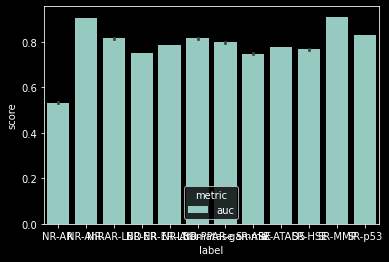

In [48]:
import seaborn as sns
sns.barplot(data = xgb_scores.query("mean_impurity_decrease == 0.01 & metric =='auc'"), 
                hue = 'metric',
                y = 'score',
                x = 'label'
               )

Test AUC performance is not great when compared against dmlab/Tox21 challenge winners. 

XGBRFClassifier with global feature selection (Worked better for AChEi dataset)

In [108]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight

xgb_scores=[]

param_grid = {'mid': [0.01], 
              'rand': range(5),
              'n_estimators': [250, 500, 1000]
             }
for params in ParameterGrid(param_grid):
    for idx, label in enumerate(labels):
        clf=xgb.XGBRFClassifier(n_estimators=params['n_estimators'], 
                                gamma = params['mid'],
                                random_state = params['rand'],
#                                 class_weight = "balanced_subsample", 
                                use_label_encoder = False
                               )
        inds = ~np.isnan(all_train_targets[:, idx])
        test_inds = ~np.isnan(test_targets[:, idx])
        
        sample_weight = compute_sample_weight('balanced', 
                      all_train_targets[inds, idx]
                     )
        clf.fit(selected_train_features[inds,:], 
                all_train_targets[inds, idx].astype(int),
                sample_weight = sample_weight, 
                eval_metric = 'logloss'
               )
        auc = roc_auc_score(test_targets[test_inds,idx].astype(int), 
                            clf.predict_proba(selected_test_features[test_inds,:])[:,1])
        f1 = f1_score(test_targets[test_inds, idx].astype(int), 
                      clf.predict(selected_test_features[test_inds, :]))
        acc = accuracy_score(test_targets[test_inds, idx].astype(int), 
                             clf.predict(selected_test_features[test_inds ,:]))
        xgb_scores.append([label, params['n_estimators'], params['mid'], params['rand'],
                     "auc",auc])
        xgb_scores.append([label, params['n_estimators'], params['mid'], params['rand'],
                     "f1",f1])
        xgb_scores.append([label, params['n_estimators'], params['mid'], params['rand'],
                     "acc",acc])
        del clf

xgb_scores = pd.DataFrame(xgb_scores, 
                         columns = ['label',
                                    'n_estimators',
                                    'mean_impurity_decrease',
                                    'rand_seed',
                                    "metric",
                                    'score'
                                   ])
xgb_scores['Clf'] = "XGBoost RF"

<AxesSubplot:xlabel='label', ylabel='score'>

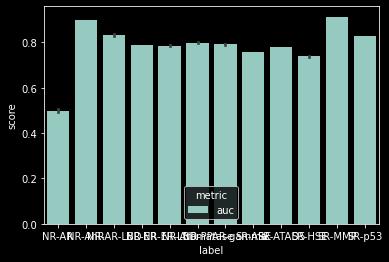

In [109]:
import seaborn as sns
sns.barplot(data = xgb_scores.query("mean_impurity_decrease == 0.01 & metric =='auc'"), 
                hue = 'metric',
                y = 'score',
                x = 'label'
               )

In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_sample_weight

rf_scores = []

param_grid = {'mid': [0.01], 
              'rand': range(5),
              'n_estimators': [250, 500, 1000]
             }
for params in ParameterGrid(param_grid):
    for idx, label in enumerate(labels):
        clf=RandomForestClassifier(n_estimators=params['n_estimators'], 
#                                 gamma = params['mid'],
                                random_state = params['rand'],
                                   min_impurity_decrease = params['mid'],
                                class_weight = "balanced_subsample", 
#                                 use_label_encoder = False
                               )
        inds = ~np.isnan(all_train_targets[:, idx])
        test_inds = ~np.isnan(test_targets[:, idx])
        
        sample_weight = compute_sample_weight('balanced', 
                      all_train_targets[inds, idx]
                     )
        clf.fit(selected_train_features[inds,:], 
                all_train_targets[inds, idx].astype(int),
                sample_weight = sample_weight, 
#                 eval_metric = 'logloss'
               )
        auc = roc_auc_score(test_targets[test_inds,idx].astype(int), 
                            clf.predict_proba(selected_test_features[test_inds,:])[:,1])
        f1 = f1_score(test_targets[test_inds, idx].astype(int), 
                      clf.predict(selected_test_features[test_inds, :]))
        acc = accuracy_score(test_targets[test_inds, idx].astype(int), 
                             clf.predict(selected_test_features[test_inds ,:]))
        rf_scores.append([label, params['n_estimators'], params['mid'], params['rand'],
                     "auc",auc])
        rf_scores.append([label, params['n_estimators'], params['mid'], params['rand'],
                     "f1",f1])
        rf_scores.append([label, params['n_estimators'], params['mid'], params['rand'],
                     "acc",acc])
        del clf

rf_scores = pd.DataFrame(rf_scores, 
                         columns = ['label',
                                    'n_estimators',
                                    'mean_impurity_decrease',
                                    'rand_seed',
                                    "metric",
                                    'score'
                                   ])
rf_scores['Clf'] = "Random Forest classifier"

<AxesSubplot:xlabel='label', ylabel='score'>

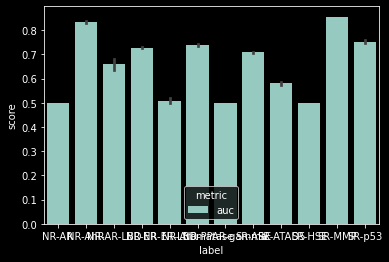

In [112]:
import seaborn as sns
sns.barplot(data = rf_scores.query("mean_impurity_decrease == 0.01 & metric =='auc'"), 
                hue = 'metric',
                y = 'score',
                x = 'label'
               )

# Dense model comparison (TBD)

Tox21_experiments_dense.py

# maml

In [5]:
import os, sys
from Tox21experiment_helper import *

sys.path.append(os.path.join("..", "..", "0_code"))

from algorithms import attention_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.regularizers import l1, l2

from tf_helpers import get_weights_dicts, BinaryCrossEntropyIgnoreNan
from tf_helpers import SimilarityBatchingDataset
from tf_helpers import AveragedAUCIgnoreNan

In [6]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.keras.backend.set_floatx('float32')


In [15]:
# Adapted from https://colab.research.google.com/github/mari-linhares/tensorflow-maml/blob/master/maml.ipynb#scrollTo=xzVi0_YfB2aZ
# on April 1st 2021
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_sample_weight
%matplotlib inline

loss_function = tf.keras.losses.BinaryCrossentropy()


def compute_loss(model, x, y, loss_fn=loss_function):
    mse = loss_fn(y, model(x))
    return mse


def get_split_loc(arr_size, split_size):
    if arr_size % split_size == 0:
        return int(arr_size/split_size)
    split_loc = [split_size*(i+1)
                 for i in range(int(np.floor(arr_size/split_size)))]
    return split_loc

# Helper class to load datasets


class MetaLearnDSLoader():
    def __init__(self,
                 X,
                 y,
                 train_size=None,
                 metatrain_size=20,
                 balanced_sampling=True,
                 shuffle=True,
                 batch_size=8,
                 similarity_batching_kwargs=None
                 ):
        """If similarity_batching is set to True, shuffle is ignored (False) and batch_size is required."""

        self.X = X
        self.y = y
        self.train_size = train_size
        self.metatrain_size = metatrain_size
        self.balanced_sampling = balanced_sampling
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.num_labels = y.shape[1]
        self.similarity_batching_kwargs = similarity_batching_kwargs

    def load_task(self, label_idx, attentions=None):
        X_task, y_task, _, attentions = self._load_valid(
            label_idx, attentions=attentions)

        # Get sample sizes
        size = y_task.shape[0]
        if self.train_size is not None:
            train_size = np.min([self.train_size, size])
        else:
            train_size = size

        #Sample and subset
        inds = self._sampling(size, train_size, y_task)
        X_task = X_task[inds, :]
        y_task = y_task[inds]
        if attentions is not None:
            attentions = attentions[inds]
        return self._shuffle_and_batch(X_task, y_task, attentions=attentions)

    def load_sample_metatrain(self, attentions=None):
        selected_ind = []
        for label_idx in range(self.num_labels):
            _, y_task, valid_ind, __ = self._load_valid(label_idx, attentions)

            # Get sample sizes
            size = y_task.shape[0]
            if self.metatrain_size is not None:
                metatrain_size = np.min([self.metatrain_size, size])
            else:
                metatrain_size = size
            #Sample and subset (task-level)
            inds = self._sampling(size, metatrain_size, y_task)
            selected_ind.append(valid_ind[inds])

        #Sample and subset (dataset-level)
        X_metatrain, y_metatrain, attentions_metatrain = self._load_metatrain(
            selected_ind, attentions)
        return self._shuffle_and_batch(X_metatrain, y_metatrain, attentions=attentions_metatrain)

    def _load_valid(self, label_idx, attentions):
        ind = ~tf.math.is_nan(self.y[:, label_idx])
        X_task = self.X[ind, :]
        y_task = self.y[ind, label_idx]
        if attentions is not None:
            attentions = attentions[ind, :]
        return X_task, y_task, np.where(ind)[0], attentions

    def _sampling(self,
                  size,
                  sample_size,
                  y_task=None,
                  random_seed=np.random.randint(np.iinfo(np.int32).max)):
        if self.balanced_sampling:
            p = compute_sample_weight("balanced", y_task)
            p = p/np.sum(p)
        else:
            p = np.ones(size)/size
        np.random.seed(random_seed)
        inds = np.random.choice(range(size),
                                size=sample_size,
                                replace=True,
                                p=p
                                )
        return inds

    def _load_metatrain(self, selected_ind, attentions):
        X_metatrain = []
        y_metatrain = []
        attentions_metatrain = []
        for label_idx, select_ind in enumerate(selected_ind):
            X_task = self.X[select_ind, :]
            y_task = self.y[select_ind, label_idx]
            X_metatrain.append(X_task)
            y_metatrain.append(y_task)
            if attentions is not None:
                attentions_task = attentions[select_ind, :]
                attentions_metatrain.append(attentions_task)
        if attentions is not None:
            attentions_metatrain = np.vstack(attentions_metatrain)
            print(f"attentions_metatrain shape {attentions_metatrain.shape}")
        return np.vstack(X_metatrain), np.concatenate(y_metatrain), attentions_metatrain

    def _shuffle_and_batch(self,
                           X, y,
                           random_seed=np.random.randint(
                               np.iinfo(np.int32).max),
                           attentions=None
                           ):
        assert len(X) == len(y), "check X and y"
        if self.similarity_batching_kwargs is not None:
            simbatched = SimilarityBatchingDataset(
                X, y, attentions,
                n_batch=self.batch_size,
                **self.similarity_batching_kwargs
            )
            X_simbatched, y_simbatched = simbatched.get_rearranged_tensor()
            return self._batch(X_simbatched), self._batch(y_simbatched)
        if self.shuffle:
            np.random.seed(random_seed)
            ind = np.random.choice(range(len(X)), len(X))
            X = X[ind]
            y = y[ind]
            y = np.expand_dims(y, axis=1)
        if self.batch_size is not None:
            return self._batch(X), self._batch(y)
        else:
            return X, y

    def _batch(self, arr):
        if self.batch_size is not None:
            split_loc = get_split_loc(arr.shape[0], self.batch_size)
            return np.split(arr, split_loc)
        else:
            return arr


def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


def train_maml(model, epochs, X_train, y_train,
               X_test=None,
               y_test=None,
               lr_inner=0.01, log_steps=10,
               interim_weights_file="interim_weights",
               saved_model_dir="LS_model",
               similarity_batching_kwargs=None, 
               weights_dict = None
               ):
    '''Train using the MAML setup.

    The comments in this function that start with:

        Step X:

    Refer to a step described in the Algorithm 1 of the paper.

    Args:
        model: A model.
        epochs: Number of epochs used for training.
        dataset: A dataset used for training.
        lr_inner: Inner learning rate (alpha in Algorithm 1). Default value is 0.01.
        batch_size: Batch size. Default value is 1. The paper does not specify
            which value they use.
        log_steps: At every `log_steps` a log message is printed.
        similarity_batching_kwargs: pass dictionary if similarity_batching is to be used. Leave as None if 'regular' shuffle batch is to be used. 

    Returns:
        A strong, fully-developed and trained maml.
    '''
#     optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)

    # Step 2: instead of checking for convergence, we train for a number
    # of epochs
    total_loss = 0
    losses = []
    metatest_scores = []
    save_best = -np.inf
    save_best_folder = os.path.join(saved_model_dir,
                                    "saved_best"
                                    )
    lr = np.float(model.optimizer.learning_rate)
    for epoch in range(epochs):
        # update learning rate
        model.optimizer.learning_rate = lr_scheduler(epoch, lr)

        start = time.time()
        # Step 3 and 4
        if epoch > 0 and similarity_batching_kwargs is not None:
            ds_loader = MetaLearnDSLoader(X_train,
                                          y_train,
                                          train_size=100,
                                          metatrain_size=100,
                                          balanced_sampling=True,
                                          batch_size=8,
                                          similarity_batching_kwargs=similarity_batching_kwargs
                                          )
            attentions = model.layers[1](X_train).numpy()
        else:
            ds_loader = MetaLearnDSLoader(X_train,
                                          y_train,
                                          train_size=100,
                                          metatrain_size=100,
                                          balanced_sampling=True,
                                          shuffle=True,
                                          batch_size=8,
                                          )
            attentions = None
        for label_idx in range(12):
            X_task_batched, y_task_batched = ds_loader.load_task(
                label_idx, attentions=attentions)
            X_metatrain_batched, y_metatrain_batched = ds_loader.load_sample_metatrain(
                attentions=attentions)
#         for i, t in enumerate(random.sample(dataset, len(dataset))):
#             x, y = np_to_tensor(t.batch())
            model(X_task_batched[0])  # run forward pass to initialize weights
            model.save_weights(interim_weights_file)
            #Update model loss 
            if weights_dict is not None:
                model.loss = BinaryCrossEntropyIgnoreNan([weights_dict[label_idx]])
            with tf.GradientTape(persistent=True) as metatrain_tape:
                # test_tape.watch(model.trainable_variables)
                # Step 5
                for batch in range(len(X_task_batched)):
                    with tf.GradientTape() as train_tape:
                        X_task = X_task_batched[batch]
                        y_task = y_task_batched[batch]
                        if y_task.ndim<2:
                            y_task = np.expand_dims(y_task, axis=1)
                        train_loss = compute_loss(model, X_task, y_task)
                    # Step 6
                    train_gradients = train_tape.gradient(
                        train_loss, model.trainable_variables)
                    model.optimizer.apply_gradients(
                        zip(train_gradients, model.trainable_variables))
#                 k = 0
#                 model_copy = copy_model(model)
#                 for j in range(1,len(model.layers)):
#                     if model.layers[j].name[:5]=='dense':
#                         model.layers[j].kernel = tf.subtract(model.layers[j].kernel,
#                                     tf.multiply(lr_inner, train_gradients[k]))
#                         model.layers[j].bias = tf.subtract(model.layers[j].bias,
#                                     tf.multiply(lr_inner, train_gradients[k+1]))
#                         k += 2
                # Step 8
                metatrain_losses = []
                for batch in range(len(X_metatrain_batched)):
                    _y = y_metatrain_batched[batch]
                    if _y.ndim<2:
                        _y = np.expand_dims(_y, axis=1)
                    metatrain_loss = compute_loss(model,
                                                  X_metatrain_batched[batch],
                                                  _y)
                    metatrain_losses.append(metatrain_loss)
                model.load_weights(interim_weights_file)
            # Step 8
            for batch in range(len(X_metatrain_batched)):
                metatrain_gradients = metatrain_tape.gradient(
                    metatrain_losses[batch], model.trainable_variables)
                model.optimizer.apply_gradients(
                    zip(metatrain_gradients, model.trainable_variables))

            # Logs
            losses.append(np.mean(metatrain_losses))

        # Evaluate and save to csv
        if X_test is not None:
            metatest_ = eval_step(model,
                                  X_test,
                                  y_test,
                                  X_train,
                                  y_train,
                                  epoch=_,
                                  csv_write=os.path.join(saved_model_dir,
                                                         "eval_log.csv"
                                                         )
                                  )
            metatest_score = np.mean(metatest_.query("metric=='AUC'")['score'])
            metatest_scores.append(metatest_score)
            if metatest_score > save_best and epoch > 9:  # Only start saving models after 10 epochs
                model.save(save_best_folder)
                save_best = metatest_score
                print(f"Epoch {epoch}, metatest_score: {metatest_score}")
        # Print log and save model
        if epoch % log_steps == 0 and epoch > 0:
            print('Step {}: metatrain_loss = {}, metatest_score = {}, Time to run {} steps = {}'.format(
                epoch,
                np.mean(metatrain_losses),
                np.mean(metatest_.query("metric=='AUC'")['score']),
                log_steps,
                time.time() - start))
            start = time.time()

    plt.plot(losses)
    plt.show()
    plt.plot(metatest_scores)
    plt.show()
    return model


def eval_maml(tf_model, X_task, y_task, thresh=0.5,
              metatest_training=False,
              X_train_batched=None,
              y_train_batched=None,
              ):
    """Evaluate maml model. 

    thresh refers to the cutoff between positive and negative prediction
    If metatest_training is True, pass X_train_batched and y_train_batched for metatest_training. """
    # metatesting-Training
    if metatest_training:
        for batch in range(len(X_train_batched)):
            with tf.GradientTape(persistent=True) as train_tape:
                train_loss = compute_loss(tf_model,
                                          X_train_batched[batch],
                                          y_train_batched[batch]
                                          )
            train_gradients = train_tape.gradient(
                train_loss, tf_model.layers[-1].trainable_variables
            )
            tf_model.optimizer.apply_gradients(
                zip(train_gradients, tf_model.layers[-1].trainable_variables)
            )
    # metatesting test
    predict = tf_model(X_task, training=False)
    predict_class = tf.cast(tf.math.greater(predict, thresh),
                            dtype=tf.int32)
    auc = roc_auc_score(y_task, predict)
    f1 = f1_score(y_task, predict_class)
    acc = accuracy_score(y_task, predict_class)

    return auc, f1, acc


def eval_step(tf_model, X_test, y_test, X_train, y_train, epoch, csv_write=None):
    results = []
    ds_loader = MetaLearnDSLoader(X=X_train,
                                  y=y_train,
                                  train_size=100,
                                  metatrain_size=100,
                                  balanced_sampling=True,
                                  shuffle=True,
                                  batch_size=8
                                  )
    for label_idx in range(test_targets.shape[1]):
        label_name = labels[label_idx]
        ind = np.where(~tf.math.is_nan(test_targets[:, label_idx]))[0]
        thresh = get_p(all_train_targets[:, label_idx])

        X_tasked_batched, y_tasked_batched = ds_loader.load_task(label_idx)
        auc, f1, acc = eval_maml(tf_model,
                                 X_task=X_test[ind, :],
                                 y_task=y_test[ind, label_idx],
                                 thresh=thresh,
                                 metatest_training=True,
                                 X_train_batched=X_tasked_batched,
                                 y_train_batched=y_tasked_batched
                                 )
        results.append([label_name, epoch, "AUC", auc])
        results.append([label_name, epoch, "f1", f1])
        results.append([label_name, epoch, "acc", acc])

    results_df = pd.DataFrame(
        results, columns=["Label", "epoch", 'metric', 'score'])
    if csv_write is not None:
        file_exists = os.path.isfile(csv_write)
        results_df.to_csv(csv_write,
                          mode='a',
                          header=~file_exists)
    return results_df

## dense model with MAML

In [16]:
from Tox21experiment_helper import load_data, get_dense_model, get_model_setup_params, get_model_compile_params
from tf_helpers import get_weights_dicts 

model_setup_params = get_model_setup_params()
model_setup_params['n_out']=1
model_setup_params['n_feat'] = 348
model_setup_params['n_hidden'] = 512
model_setup_params['concat_activation'] = tf.nn.leaky_relu
model_setup_params['hidden_activation'] = tf.nn.leaky_relu

weights_dict = get_weights_dicts(all_train_targets)
model_compile_params_0 = get_model_compile_params(weights_dict[0], 
                                                0.001)
model_compile_params_0['metrics'] = [AveragedAUCIgnoreNan(num_labels = 1)]
dense_model = get_dense_model(**model_setup_params)
dense_model.compile(**model_compile_params_0)

INFO:tensorflow:Assets written to: MAML\dense_model\20210410_dense_model\saved_best\assets


INFO:tensorflow:Assets written to: MAML\dense_model\20210410_dense_model\saved_best\assets


Epoch 10, metatest_score: 0.7568146041235574
Step 10: metatrain_loss = 0.531293511390686, metatest_score = 0.7568146041235574, Time to run 10 steps = 44.30292582511902
INFO:tensorflow:Assets written to: MAML\dense_model\20210410_dense_model\saved_best\assets


INFO:tensorflow:Assets written to: MAML\dense_model\20210410_dense_model\saved_best\assets


Epoch 11, metatest_score: 0.7573246347394504
INFO:tensorflow:Assets written to: MAML\dense_model\20210410_dense_model\saved_best\assets


INFO:tensorflow:Assets written to: MAML\dense_model\20210410_dense_model\saved_best\assets


Epoch 12, metatest_score: 0.7573288728606983
Step 20: metatrain_loss = 0.5095348954200745, metatest_score = 0.7570223732936826, Time to run 10 steps = 45.97181797027588
Step 30: metatrain_loss = 0.4891608655452728, metatest_score = 0.7527457134956452, Time to run 10 steps = 45.387948751449585
Step 40: metatrain_loss = 0.5109307765960693, metatest_score = 0.7511573800218257, Time to run 10 steps = 46.315857887268066
Step 50: metatrain_loss = 0.4571715295314789, metatest_score = 0.7498602958418017, Time to run 10 steps = 44.58701467514038
Step 60: metatrain_loss = 0.4511300027370453, metatest_score = 0.7476777581823816, Time to run 10 steps = 40.85865139961243
Step 70: metatrain_loss = 0.4512377977371216, metatest_score = 0.7480219530445624, Time to run 10 steps = 40.20129466056824
Step 80: metatrain_loss = 0.42645975947380066, metatest_score = 0.7463921234234808, Time to run 10 steps = 41.226012229919434
Step 90: metatrain_loss = 0.4391321837902069, metatest_score = 0.7454318294533541, 

Step 670: metatrain_loss = 0.14333488047122955, metatest_score = 0.7169904998342361, Time to run 10 steps = 42.48518466949463
Step 680: metatrain_loss = 0.14129894971847534, metatest_score = 0.7165096302778197, Time to run 10 steps = 43.068204402923584
Step 690: metatrain_loss = 0.13921409845352173, metatest_score = 0.7153461463573052, Time to run 10 steps = 44.486260175704956
Step 700: metatrain_loss = 0.13741183280944824, metatest_score = 0.7145604638024419, Time to run 10 steps = 42.33627533912659
Step 710: metatrain_loss = 0.13462600111961365, metatest_score = 0.7128502733658263, Time to run 10 steps = 42.284260511398315
Step 720: metatrain_loss = 0.13167758285999298, metatest_score = 0.712198066580175, Time to run 10 steps = 42.77600383758545
Step 730: metatrain_loss = 0.12802566587924957, metatest_score = 0.7112221303652451, Time to run 10 steps = 43.30906343460083
Step 740: metatrain_loss = 0.12680679559707642, metatest_score = 0.7100206145010678, Time to run 10 steps = 43.28398

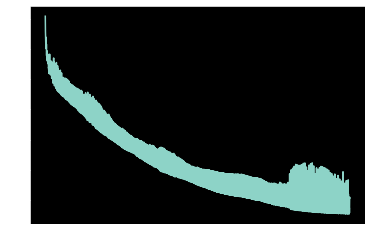

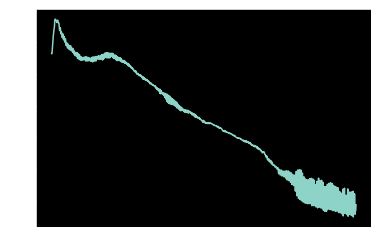

In [18]:
saved_model_dir = os.path.join("MAML", 
                               "dense_model", 
                               time.strftime("%Y%m%d_dense_model")
                              )
try:
    os.mkdir(saved_model_dir)
except:
    pass
model = train_maml(dense_model,
                   epochs=1000,
                   X_train=selected_train_features,
                   y_train=all_train_targets,
                   X_test=selected_test_features, 
                   y_test=test_targets,
                   saved_model_dir=saved_model_dir,
                   weights_dict = weights_dict
                   )

In [24]:
from tf_helpers import BinaryCrossEntropyIgnoreNan, AveragedAUCIgnoreNan

saved_model_dir = os.path.join("MAML", 
                               "dense_model", 
                               "20210410_dense_model", 
                               "saved_best"
                              )
dense_model = tf.keras.models.load_model(saved_model_dir, 
                                         custom_objects = {
        "BinaryCrossEntropyIgnoreNan": BinaryCrossEntropyIgnoreNan,
        "AveragedAUCIgnoreNan": AveragedAUCIgnoreNan
                                         }
                                        )

In [25]:
results = []
ds_loader = MetaLearnDSLoader(X=selected_train_features,
                              y=all_train_targets,
                              train_size=100,
                              metatrain_size=100,
                              balanced_sampling=True,
                              shuffle=True,
                              batch_size=8
                              )
for label_idx in range(test_targets.shape[1]):
    label_name = labels[label_idx]
    ind = np.where(~tf.math.is_nan(test_targets[:, label_idx]))[0]
    thresh = get_p(all_train_targets[:, label_idx])
    
    X_tasked_batched, y_tasked_batched = ds_loader.load_task(label_idx)
    auc, f1, acc = eval_maml(LS_model, 
                             X_task = selected_test_features[ind, :], 
                             y_task = test_targets[ind, label_idx], 
                             thresh = thresh, 
                             metatest_training = True, 
                             X_train_batched = X_tasked_batched,
                             y_train_batched = y_tasked_batched
                            )
    results.append([label_name, "AUC", auc])
    results.append([label_name, "f1", f1])
    results.append([label_name, "acc", acc])
    
results_df = pd.DataFrame(results, columns = ["Label", 'metric', 'score'])

In [26]:
results_df.query("metric=='AUC'")

,Label,metric,score
0,NR-AR,AUC,0.686353
3,NR-AhR,AUC,0.821394
6,NR-AR-LBD,AUC,0.724599
9,NR-ER,AUC,0.771597
12,NR-ER-LBD,AUC,0.746825
15,NR-Aromatase,AUC,0.809966
18,NR-PPAR-gamma,AUC,0.729781
21,SR-ARE,AUC,0.739985
24,SR-ATAD5,AUC,0.705376
27,SR-HSE,AUC,0.718690


## MAML with attention with Feature weights

In [81]:
from Tox21experiment_helper import load_data, get_dense_model, get_attentionwFW_model, get_model_setup_params, get_model_compile_params
from tf_helpers import get_weights_dicts 

model_setup_params = get_model_setup_params()
model_setup_params['n_out']=1
model_setup_params['n_attention']=5
model_setup_params['n_feat'] = 348 
model_setup_params['n_hidden'] = 512
model_setup_params['concat_activation'] = tf.nn.leaky_relu
model_setup_params['hidden_activation'] = tf.nn.leaky_relu
model_setup_params['attention_hidden_activation'] = tf.nn.leaky_relu

weights_dict = get_weights_dicts(all_train_targets)
model_compile_params_0 = get_model_compile_params([weights_dict[0]], 
                                                0.001)
model_compile_params_0['metrics'] = [AveragedAUCIgnoreNan(num_labels = 1)]
LSwFW_model = get_attentionwFW_model(**model_setup_params)
LSwFW_model.compile(**model_compile_params_0)

Fitted 20 clusters with distribution [40 26  5  4  4  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [741 110  73  71  51  46  23  21  18  14  13   6   3   2   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [20 15 13 12  6  6  5  5  4  2  2  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [741 110  73  71  51  46  23  21  18  14  13   6   3   2   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [43 11  6  6  5  4  3  3  3  2  2  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [741 110  73  71  51  46  23  21  18  14  13   6   3   2   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [30 25  7  6  6  4  3  3  3  2  2  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [741 110  73  71  51  46  23  21  18  14  13   6   

Fitted 20 clusters with distribution [33 12  7  7  7  6  4  4  3  3  3  2  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [738 134  75  69  63  35  26  21  16   6   3   3   3   2   1   1   1   1
   1   1]
Fitted 20 clusters with distribution [25 14 11 10  5  5  4  4  3  3  3  2  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [738 134  75  69  63  35  26  21  16   6   3   3   3   2   1   1   1   1
   1   1]
Fitted 20 clusters with distribution [55  7  5  5  3  3  3  2  2  2  2  2  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [738 134  75  69  63  35  26  21  16   6   3   3   3   2   1   1   1   1
   1   1]
Fitted 20 clusters with distribution [41 13 10  7  3  3  3  3  3  2  2  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [738 134  75  69  63  35  26  21  16   6   3   3   

Fitted 20 clusters with distribution [31 17 12  8  5  4  4  4  2  2  2  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [799 115  75  67  57  18  18  17   8   6   5   4   3   2   1   1   1   1
   1   1]
Fitted 20 clusters with distribution [41 14 13  6  4  4  3  2  2  1  1  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [799 115  75  67  57  18  18  17   8   6   5   4   3   2   1   1   1   1
   1   1]
Fitted 20 clusters with distribution [42  5  5  5  5  5  4  4  4  3  3  3  3  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [799 115  75  67  57  18  18  17   8   6   5   4   3   2   1   1   1   1
   1   1]
Fitted 20 clusters with distribution [35 11 10  8  6  6  4  4  2  2  2  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [799 115  75  67  57  18  18  17   8   6   5   4   

Fitted 20 clusters with distribution [42 23  6  5  3  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [811 111  75  67  58  21  18  12   6   6   4   2   2   1   1   1   1   1
   1   1]
Fitted 20 clusters with distribution [20 18 12 12  6  6  6  4  4  2  1  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [811 111  75  67  58  21  18  12   6   6   4   2   2   1   1   1   1   1
   1   1]
Fitted 20 clusters with distribution [46 10  7  7  3  3  3  3  2  2  2  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [811 111  75  67  58  21  18  12   6   6   4   2   2   1   1   1   1   1
   1   1]
Fitted 20 clusters with distribution [29 17 15  9  7  3  3  2  2  2  2  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [811 111  75  67  58  21  18  12   6   6   4   2   

INFO:tensorflow:Assets written to: MAML\LSwFW_model\20210407_LSwFW_model_SimilarityBatching\saved_best\assets


INFO:tensorflow:Assets written to: MAML\LSwFW_model\20210407_LSwFW_model_SimilarityBatching\saved_best\assets


Epoch 10, metatest_score: 0.711380648908645
Step 10: metatrain_loss = 0.5377601981163025, metatest_score = 0.711380648908645, Time to run 10 steps = 133.9033236503601
Fitted 20 clusters with distribution [38 19  8  7  5  3  2  2  2  2  2  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [795 123  75  67  58  21  20  17   6   6   2   2   1   1   1   1   1   1
   1   1]
Fitted 20 clusters with distribution [29 14 14  6  6  6  5  4  4  2  1  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [795 123  75  67  58  21  20  17   6   6   2   2   1   1   1   1   1   1
   1   1]
Fitted 20 clusters with distribution [46 10  7  7  3  3  3  3  2  2  2  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [795 123  75  67  58  21  20  17   6   6   2   2   1   1   1   1   1   1
   1   1]
Fitted 20 clusters with distribution [22 20 12  9  7  5  4 

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [690 166 120  75  52  22  21  14  14   6   5   4   3   2   1   1   1   1
   1   1]
Fitted 20 clusters with distribution [27 12  9  7  7  6  5  4  4  3  3  3  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [690 166 120  75  52  22  21  14  14   6   5   4   3   2   1   1   1   1
   1   1]
Fitted 20 clusters with distribution [21 20  7  6  6  5  5  4  4  3  3  3  2  2  2  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [690 166 120  75  52  22  21  14  14   6   5   4   3   2   1   1   1   1
   1   1]
Fitted 20 clusters with distribution [56  7  5  5  3  3  3  2  2  2  2  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [690 166 120  75  52  22  21  14  14   6   5   4   3   2   1   1   1   1
   1   1]
Fitted 20 clusters with distribution [31 18 14  7  4  3  3  3  3  2

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [625 189 120  92  59  49  17  13   8   7   6   3   2   2   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [24 20 12  8  5  4  4  4  4  3  2  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [625 189 120  92  59  49  17  13   8   7   6   3   2   2   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [31 18 13  8  4  4  4  3  2  2  2  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [625 189 120  92  59  49  17  13   8   7   6   3   2   2   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [41  7  7  5  5  5  4  4  3  3  3  3  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [625 189 120  92  59  49  17  13   8   7   6   3   2   2   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [34 11  9  8  7  6  4  4  4  2

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [790 111  92  78  59  19  11   9   6   6   5   3   2   2   2   1   1   1
   1   1]
Fitted 20 clusters with distribution [38 28  5  5  3  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [779 122  88  78  50  17  16  11   9   6   6   5   3   2   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [27 16  8  6  6  6  6  5  4  4  2  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [779 122  88  78  50  17  16  11   9   6   6   5   3   2   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [49 17  6  3  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [779 122  88  78  50  17  16  11   9   6   6   5   3   2   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [22 19 11  9  7  7  5  3  3  2

Fitted 20 clusters with distribution [21 13 11  9  8  7  6  4  4  4  2  2  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [756 109  87  79  58  25  22  17  11   8   6   5   4   4   2   2   2   1
   1   1]
Fitted 20 clusters with distribution [27 13  9  7  7  6  4  4  4  3  3  3  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [756 109  87  79  58  25  22  17  11   8   6   5   4   4   2   2   2   1
   1   1]
Fitted 20 clusters with distribution [22 12 11 11  6  5  5  4  3  3  3  2  2  2  2  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [756 109  87  79  58  25  22  17  11   8   6   5   4   4   2   2   2   1
   1   1]
Fitted 20 clusters with distribution [38 16  7  5  5  3  3  3  3  2  2  2  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [756 109  87  79  58  25  22  17  11   8   6   5   

Fitted 20 clusters with distribution [37 14  9  7  5  5  3  3  3  2  2  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [791 115  88  78  58  18  12   8   6   5   4   4   3   2   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [24 19 14 10  5  4  4  4  2  2  2  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [791 115  88  78  58  18  12   8   6   5   4   4   3   2   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [32 18 12  4  4  4  4  4  3  2  2  2  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [791 115  88  78  58  18  12   8   6   5   4   4   3   2   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [43  7  5  5  4  4  4  4  3  3  3  3  3  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [791 115  88  78  58  18  12   8   6   5   4   4   

Fitted 20 clusters with distribution [35 14 14  7  4  3  3  3  3  2  2  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [664 197 115  92  59  16  12  12   6   6   4   4   3   2   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [41 19  7  6  4  3  3  2  2  2  2  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [672 196 115  92  59  12  12   8   6   6   4   4   3   3   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [23 14 11  8  6  6  6  6  4  4  2  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [672 196 115  92  59  12  12   8   6   6   4   4   3   3   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [44 17  6  5  3  3  2  2  2  2  2  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [672 196 115  92  59  12  12   8   6   6   4   4   

Fitted 20 clusters with distribution [21 12 12  9  8  7  6  4  4  4  2  2  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [478 321  95  92  87  67  12  12   6   6   6   4   3   3   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [29  9  8  7  6  6  5  5  3  3  3  3  2  2  2  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [478 321  95  92  87  67  12  12   6   6   6   4   3   3   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [13 13 10 10  8  7  6  5  5  4  3  3  2  2  2  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [478 321  95  92  87  67  12  12   6   6   6   4   3   3   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [38 16  7  6  4  3  3  3  3  2  2  2  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [478 321  95  92  87  67  12  12   6   6   6   4   

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [329 296 253  93  67  58  36  19  12   7   6   6   4   4   3   2   2   1
   1   1]
Fitted 20 clusters with distribution [26 15 10  9  7  5  5  3  3  3  3  2  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [329 296 253  93  67  58  36  19  12   7   6   6   4   4   3   2   2   1
   1   1]
Fitted 20 clusters with distribution [24 19 11  8  5  5  4  4  4  3  3  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [329 296 253  93  67  58  36  19  12   7   6   6   4   4   3   2   2   1
   1   1]
Fitted 20 clusters with distribution [32 18 12  4  4  4  4  4  3  2  2  2  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [329 296 253  93  67  58  36  19  12   7   6   6   4   4   3   2   2   1
   1   1]
Fitted 20 clusters with distribution [43  7  5  5  4  4  4  4  3  3

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [313 270 222 104  93  69  58  16  12  11   7   6   6   4   3   2   1   1
   1   1]
Fitted 20 clusters with distribution [19 16 14 12 10  6  4  3  2  2  2  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [313 270 222 104  93  69  58  16  12  11   7   6   6   4   3   2   1   1
   1   1]
Fitted 20 clusters with distribution [41 16  7  6  4  4  3  3  2  2  2  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [512 279 104  93  67  55  18  14  14  12  12   6   4   3   2   1   1   1
   1   1]
Fitted 20 clusters with distribution [18 14 11 11  6  6  6  5  5  3  3  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [512 279 104  93  67  55  18  14  14  12  12   6   4   3   2   1   1   1
   1   1]
Fitted 20 clusters with distribution [38 17  7  6  5  3  3  3  2  2

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [338 297 239  93  82  69  20  12  11   8   7   6   6   3   3   2   1   1
   1   1]
Fitted 20 clusters with distribution [15 12 11 10  8  7  6  6  4  4  3  2  2  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [338 297 239  93  82  69  20  12  11   8   7   6   6   3   3   2   1   1
   1   1]
Fitted 20 clusters with distribution [29  9  9  7  6  6  5  5  3  3  3  2  2  2  2  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [338 297 239  93  82  69  20  12  11   8   7   6   6   3   3   2   1   1
   1   1]
Fitted 20 clusters with distribution [13 13 10  9  8  7  6  6  5  4  3  3  2  2  2  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [338 297 239  93  82  69  20  12  11   8   7   6   6   3   3   2   1   1
   1   1]
Fitted 20 clusters with distribution [27 13 11  7  6  5  5  3  3  3

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [343 283 239  93  93  69  19  13  12   8   6   6   4   3   3   2   1   1
   1   1]
Fitted 20 clusters with distribution [26 15 11  9  7  5  3  3  3  3  3  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [343 283 239  93  93  69  19  13  12   8   6   6   4   3   3   2   1   1
   1   1]
Fitted 20 clusters with distribution [24 14 11 10  8  5  4  4  4  3  3  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [343 283 239  93  93  69  19  13  12   8   6   6   4   3   3   2   1   1
   1   1]
Fitted 20 clusters with distribution [32 12 11  7  4  4  4  4  4  3  2  2  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [343 283 239  93  93  69  19  13  12   8   6   6   4   3   3   2   1   1
   1   1]
Fitted 20 clusters with distribution [37  7  7  6  5  5  4  4  4  3

Fitted 20 clusters with distribution [27 13 11  7  6  5  5  3  3  3  3  2  2  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [453 249 165  93  67  59  23  19  14  12  11   8   6   6   4   4   3   2
   1   1]
Fitted 20 clusters with distribution [19 16 16 10 10  6  3  3  2  2  2  2  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [453 249 165  93  67  59  23  19  14  12  11   8   6   6   4   4   3   2
   1   1]
Fitted 20 clusters with distribution [41 16  7  6  4  4  4  3  2  2  2  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [321 291 280  93  67  55  18  14  12  10   6   6   6   6   4   4   3   2
   1   1]
Fitted 20 clusters with distribution [19 12 11  8  6  6  5  5  5  4  4  3  2  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [321 291 280  93  67  55  18  14  12  10   6   6   

Fitted 20 clusters with distribution [17 17  7  7  6  6  6  5  4  4  4  3  3  3  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [307 301 160 100  94  93  55  18  16  14  10   6   6   5   4   4   3   2
   1   1]
Fitted 20 clusters with distribution [18 11 11 10  9  8  6  4  4  3  3  2  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [307 301 160 100  94  93  55  18  16  14  10   6   6   5   4   4   3   2
   1   1]
Fitted 20 clusters with distribution [21 10  9  8  7  7  6  6  3  3  3  3  2  2  2  2  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [307 301 160 100  94  93  55  18  16  14  10   6   6   5   4   4   3   2
   1   1]
Fitted 20 clusters with distribution [13 12 12 10 10  7  5  4  4  3  3  3  3  2  2  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [307 301 160 100  94  93  55  18  16  14  10   6   

Fitted 20 clusters with distribution [40 17  6  6  3  3  3  3  2  2  2  2  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [325 307 250  95  88  58  14  13  10   6   6   6   5   4   4   3   2   2
   1   1]
Fitted 20 clusters with distribution [26 15 11  9  7  5  3  3  3  3  3  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [325 307 250  95  88  58  14  13  10   6   6   6   5   4   4   3   2   2
   1   1]
Fitted 20 clusters with distribution [31 15 11  7  5  5  4  4  3  3  2  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [325 307 250  95  88  58  14  13  10   6   6   6   5   4   4   3   2   2
   1   1]
Fitted 20 clusters with distribution [13 13 12 11  9  7  4  4  4  4  4  4  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [325 307 250  95  88  58  14  13  10   6   6   6   

Fitted 20 clusters with distribution [27 13 11  7  6  5  5  3  3  3  3  2  2  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [353 292 217  97  93  88  13   6   6   6   5   4   4   4   3   3   2   2
   1   1]
Fitted 20 clusters with distribution [18 14 10 10 10  7  6  5  3  2  2  2  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [353 292 217  97  93  88  13   6   6   6   5   4   4   4   3   3   2   2
   1   1]
Step 50: metatrain_loss = 0.4169765114784241, metatest_score = 0.682788743220554, Time to run 10 steps = 124.82824921607971
Fitted 20 clusters with distribution [41 16  7  5  4  4  4  3  3  2  2  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [314 297 263  88  88  39  21  18  14  13  11   6   6   5   4   4   3   3
   2   1]
Fitted 20 clusters with distribution [20 12  8  7  6  6  6  5  5  5  4  3  3  2  2  2  1  1  1  1]
att

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [341 282 197  89  88  71  39  19  18  13  11   6   6   5   4   3   3   2
   2   1]
Fitted 20 clusters with distribution [20 17  7  7  6  6  5  4  4  4  3  3  3  3  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [341 282 197  89  88  71  39  19  18  13  11   6   6   5   4   3   3   2
   2   1]
Fitted 20 clusters with distribution [12 11  9  9  9  8  7  7  6  4  3  3  2  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [341 282 197  89  88  71  39  19  18  13  11   6   6   5   4   3   3   2
   2   1]
Fitted 20 clusters with distribution [18 10  9  8  7  7  6  6  5  3  3  3  3  2  2  2  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [341 282 197  89  88  71  39  19  18  13  11   6   6   5   4   3   3   2
   2   1]
Fitted 20 clusters with distribution [12 12 12 10 10  7  7  6  5  3

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [329 286 251  88  87  68  16  14  13  10   9   6   6   5   4   2   2   2
   1   1]
Fitted 20 clusters with distribution [44 17  6  3  3  3  3  2  2  2  2  2  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [329 286 251  88  87  68  16  14  13  10   9   6   6   5   4   2   2   2
   1   1]
Fitted 20 clusters with distribution [26 14 11  9  7  5  4  4  3  3  3  2  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [329 286 251  88  87  68  16  14  13  10   9   6   6   5   4   2   2   2
   1   1]
Fitted 20 clusters with distribution [24 15 11  9  7  5  5  4  4  3  3  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [329 286 251  88  87  68  16  14  13  10   9   6   6   5   4   2   2   2
   1   1]
Fitted 20 clusters with distribution [13 13 12 11  9  7  4  4  4  4

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [348 261 230 101 100  87  20  13   6   6   6   4   4   3   3   2   2   2
   1   1]
Fitted 20 clusters with distribution [27 11  9  8  8  5  5  5  3  3  3  2  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [348 261 230 101 100  87  20  13   6   6   6   4   4   3   3   2   2   2
   1   1]
Fitted 20 clusters with distribution [17 12 11 10 10 10  6  3  3  3  2  2  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [348 261 230 101 100  87  20  13   6   6   6   4   4   3   3   2   2   2
   1   1]
Fitted 20 clusters with distribution [41 16  7  5  4  4  4  3  3  2  2  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [356 259 218  88  88  71  29  20  15  14  13   6   6   5   4   2   2   2
   1   1]
Fitted 20 clusters with distribution [18 11 11  8  7  6  6  6  5  4

Fitted 20 clusters with distribution [14 12 12 11  9  7  4  4  4  4  4  4  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [304 247 227 149  89  88  19  16  15  14   6   6   6   4   2   2   2   2
   1   1]
Fitted 20 clusters with distribution [17 13 10  7  7  7  6  6  4  4  3  3  3  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [304 247 227 149  89  88  19  16  15  14   6   6   6   4   2   2   2   2
   1   1]
Fitted 20 clusters with distribution [12 11  9  9  9  8  7  7  6  4  3  3  2  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [304 247 227 149  89  88  19  16  15  14   6   6   6   4   2   2   2   2
   1   1]
Fitted 20 clusters with distribution [18 10  9  8  7  7  6  6  5  3  3  3  3  2  2  2  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [304 247 227 149  89  88  19  16  15  14   6   6   

Fitted 20 clusters with distribution [20 11 10  8  7  6  6  6  5  4  3  3  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [247 242 236 166  90  88  61  19  16   6   6   6   4   3   2   2   2   2
   1   1]
Fitted 20 clusters with distribution [41 16  6  5  3  3  3  3  3  2  2  2  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [247 242 236 166  90  88  61  19  16   6   6   6   4   3   2   2   2   2
   1   1]
Fitted 20 clusters with distribution [18 17 11  9  9  7  5  4  3  3  3  2  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [247 242 236 166  90  88  61  19  16   6   6   6   4   3   2   2   2   2
   1   1]
Fitted 20 clusters with distribution [24 15 10  9  7  5  4  4  3  3  3  3  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [247 242 236 166  90  88  61  19  16   6   6   6   

Fitted 20 clusters with distribution [13 12 10 10  8  7  7  6  5  4  3  3  2  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [256 236 210  95  90  88  84  64  18  16  16   6   6   4   3   2   2   2
   1   1]
Fitted 20 clusters with distribution [21 20  8  8  7  5  5  3  3  3  2  2  2  2  2  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [256 236 210  95  90  88  84  64  18  16  16   6   6   4   3   2   2   2
   1   1]
Fitted 20 clusters with distribution [14 13 11 11 10  7  6  6  3  3  2  2  2  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [256 236 210  95  90  88  84  64  18  16  16   6   6   4   3   2   2   2
   1   1]
Fitted 20 clusters with distribution [41 16  7  5  4  4  4  3  3  2  2  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [254 235 204 165  90  88  84  19  16  16   6   6   

Fitted 20 clusters with distribution [14 12 12 11  9  7  6  4  4  4  4  3  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [268 243 191  90  88  84  77  68  24  22  16   6   6   4   3   3   2   2
   2   1]
Fitted 20 clusters with distribution [17 10 10  7  7  7  6  6  4  4  3  3  3  3  2  2  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [268 243 191  90  88  84  77  68  24  22  16   6   6   4   3   3   2   2
   2   1]
Fitted 20 clusters with distribution [13 11  9  9  8  8  8  6  6  4  3  3  2  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [268 243 191  90  88  84  77  68  24  22  16   6   6   4   3   3   2   2
   2   1]
Fitted 20 clusters with distribution [22 12 10  9  7  7  6  3  3  3  2  2  2  2  2  2  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [268 243 191  90  88  84  77  68  24  22  16   6   

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [250 217 193 160  91  90  80  25  22  16  15  15   6   6   4   3   2   2
   2   1]
Fitted 20 clusters with distribution [13 11  8  7  7  7  7  6  6  6  6  4  3  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [250 217 193 160  91  90  80  25  22  16  15  15   6   6   4   3   2   2
   2   1]
Fitted 20 clusters with distribution [42 16  6  5  5  3  3  2  2  2  2  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [250 217 193 160  91  90  80  25  22  16  15  15   6   6   4   3   2   2
   2   1]
Fitted 20 clusters with distribution [16 14 10  9  9  7  7  6  4  3  3  3  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [250 217 193 160  91  90  80  25  22  16  15  15   6   6   4   3   2   2
   2   1]
Fitted 20 clusters with distribution [24 14 11  9  7  5  5  4  4  3

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [240 205 160 156 102  90  80  43  21  19  19  19  15  15   6   3   2   2
   2   1]
Fitted 20 clusters with distribution [13 12 10 10  8  7  7  6  5  4  3  3  2  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [240 205 160 156 102  90  80  43  21  19  19  19  15  15   6   3   2   2
   2   1]
Fitted 20 clusters with distribution [21 17  8  8  8  5  5  5  3  3  2  2  2  2  2  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [240 205 160 156 102  90  80  43  21  19  19  19  15  15   6   3   2   2
   2   1]
Fitted 20 clusters with distribution [18 11 10 10  7  7  7  6  4  3  2  2  2  2  2  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [240 205 160 156 102  90  80  43  21  19  19  19  15  15   6   3   2   2
   2   1]
Fitted 20 clusters with distribution [41 16  7  5  4  4  4  3  3  2

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [247 212 166 148  91  82  74  48  24  22  17  17  15  14   6   6   6   2
   2   1]
Fitted 20 clusters with distribution [14 12 12 11  9  7  6  4  4  4  4  3  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [247 212 166 148  91  82  74  48  24  22  17  17  15  14   6   6   6   2
   2   1]
Fitted 20 clusters with distribution [17 15 10  7  7  6  6  4  4  3  3  3  3  2  2  2  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [247 212 166 148  91  82  74  48  24  22  17  17  15  14   6   6   6   2
   2   1]
Fitted 20 clusters with distribution [13 11  9  9  8  8  8  6  6  4  3  3  2  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [247 212 166 148  91  82  74  48  24  22  17  17  15  14   6   6   6   2
   2   1]
Fitted 20 clusters with distribution [14 12 10 10  9  7  7  6  3  3

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [282 177 148 115 100  96  92  91  17  17  15  14  11   6   6   5   3   2
   2   1]
Fitted 20 clusters with distribution [12 11  8  7  7  7  6  6  6  6  6  4  3  3  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [282 177 148 115 100  96  92  91  17  17  15  14  11   6   6   5   3   2
   2   1]
Fitted 20 clusters with distribution [41 16  6  6  5  3  3  2  2  2  2  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [282 177 148 115 100  96  92  91  17  17  15  14  11   6   6   5   3   2
   2   1]
Fitted 20 clusters with distribution [16 12 10  9  8  7  7  5  4  4  4  3  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [282 177 148 115 100  96  92  91  17  17  15  14  11   6   6   5   3   2
   2   1]
Fitted 20 clusters with distribution [24 14  9  8  7  7  5  4  4  3

Fitted 20 clusters with distribution [18 12 10  9  7  7  6  6  3  3  3  2  2  2  2  2  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [282 168 147 126 100  93  91  82  18  17  15  14  14  11   6   6   5   2
   2   1]
Fitted 20 clusters with distribution [13 12 10 10 10  8  6  5  4  4  3  3  2  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [282 168 147 126 100  93  91  82  18  17  15  14  14  11   6   6   5   2
   2   1]
Fitted 20 clusters with distribution [21 12  9  9  8  6  5  5  5  3  2  2  2  2  2  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [282 168 147 126 100  93  91  82  18  17  15  14  14  11   6   6   5   2
   2   1]
Fitted 20 clusters with distribution [18 14 11 10  7  7  6  5  3  2  2  2  2  2  2  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [282 168 147 126 100  93  91  82  18  17  15  14  1

Fitted 20 clusters with distribution [24 14  9  8  7  6  5  5  4  3  3  3  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [243 210 155 122  92  91  89  78  46  17  15  14   6   6   4   4   3   2
   2   1]
Fitted 20 clusters with distribution [14 12 12  9  8  7  6  6  4  4  3  3  3  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [243 210 155 122  92  91  89  78  46  17  15  14   6   6   4   4   3   2
   2   1]
Fitted 20 clusters with distribution [15 14 10  9  7  7  6  4  4  3  3  3  3  2  2  2  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [243 210 155 122  92  91  89  78  46  17  15  14   6   6   4   4   3   2
   2   1]
Fitted 20 clusters with distribution [11 11  9  9  8  8  8  6  6  4  4  3  3  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [243 210 155 122  92  91  89  78  46  17  15  14   

Fitted 20 clusters with distribution [38 13  7  5  5  5  4  4  3  3  3  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [280 199 162 160 107  91  48  36  31  19  17  15   9   6   6   4   4   3
   2   1]
Fitted 20 clusters with distribution [14 12 11  7  7  7  7  6  6  5  3  3  3  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [280 199 162 160 107  91  48  36  31  19  17  15   9   6   6   4   4   3
   2   1]
Fitted 20 clusters with distribution [42 16  6  5  5  3  3  2  2  2  2  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [280 199 162 160 107  91  48  36  31  19  17  15   9   6   6   4   4   3
   2   1]
Fitted 20 clusters with distribution [16 15 10  9  8  7  5  4  4  4  4  3  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [280 199 162 160 107  91  48  36  31  19  17  15   

Fitted 20 clusters with distribution [18 12 10  9  7  7  6  6  3  3  3  2  2  2  2  2  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [300 245 127  95  92  92  90  76  19  16  13   9   6   6   4   3   3   2
   1   1]
Fitted 20 clusters with distribution [13 12 10 10 10  8  6  5  4  4  3  3  2  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [300 245 127  95  92  92  90  76  19  16  13   9   6   6   4   3   3   2
   1   1]
Fitted 20 clusters with distribution [21 16 11 10  9  5  5  3  3  2  2  2  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [300 245 127  95  92  92  90  76  19  16  13   9   6   6   4   3   3   2
   1   1]
Fitted 20 clusters with distribution [14 12 12 11 11  7  6  6  3  3  2  2  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [300 245 127  95  92  92  90  76  19  16  13   9   

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [301 188 151 124 102  78  77  76  19  17  14  14  12   9   6   4   3   2
   2   1]
Fitted 20 clusters with distribution [24 15  9  8  7  6  5  4  4  3  3  3  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [301 188 151 124 102  78  77  76  19  17  14  14  12   9   6   4   3   2
   2   1]
Fitted 20 clusters with distribution [14 12 12  9  8  7  6  6  4  4  3  3  3  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [301 188 151 124 102  78  77  76  19  17  14  14  12   9   6   4   3   2
   2   1]
Fitted 20 clusters with distribution [15 14 10  9  7  7  6  4  4  3  3  3  3  2  2  2  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [301 188 151 124 102  78  77  76  19  17  14  14  12   9   6   4   3   2
   2   1]
Fitted 20 clusters with distribution [11 10  9  8  8  8  8  7  6  4

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [311 253 192  92  90  78  77  21  19  15  14  13   6   6   4   3   2   2
   1   1]
Fitted 20 clusters with distribution [38 13  7  5  5  5  4  4  3  3  3  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [300 233 189  96  90  89  77  25  21  19  17  13   9   6   4   4   3   2
   2   1]
Fitted 20 clusters with distribution [14 12 11  8  7  7  6  5  5  4  4  3  3  2  2  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [300 233 189  96  90  89  77  25  21  19  17  13   9   6   4   4   3   2
   2   1]
Fitted 20 clusters with distribution [42 16  6  5  5  3  3  2  2  2  2  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [300 233 189  96  90  89  77  25  21  19  17  13   9   6   4   4   3   2
   2   1]
Fitted 20 clusters with distribution [21  9  9  8  7  7  6  5  4  4

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [332 182 132 101  90  89  89  80  31  19  13  12   6   6   5   4   3   3
   2   1]
Fitted 20 clusters with distribution [18 12 10  9  7  7  6  6  3  3  3  2  2  2  2  2  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [332 182 132 101  90  89  89  80  31  19  13  12   6   6   5   4   3   3
   2   1]
Fitted 20 clusters with distribution [13 12 10 10 10  8  6  5  4  4  3  3  2  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [332 182 132 101  90  89  89  80  31  19  13  12   6   6   5   4   3   3
   2   1]
Fitted 20 clusters with distribution [21 16 11 10  9  5  5  3  3  2  2  2  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [332 182 132 101  90  89  89  80  31  19  13  12   6   6   5   4   3   3
   2   1]
Fitted 20 clusters with distribution [15 14 11 10  7  7  6  6  4  3

Fitted 20 clusters with distribution [24  9  9  8  7  7  6  5  4  4  3  3  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [318 178 130 101  91  90  89  79  31  19  18  12  12   9   6   6   5   3
   2   1]
Fitted 20 clusters with distribution [24 15  9  8  7  6  5  4  4  3  3  3  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [318 178 130 101  91  90  89  79  31  19  18  12  12   9   6   6   5   3
   2   1]
Fitted 20 clusters with distribution [14 12 12  9  8  7  6  6  4  4  3  3  3  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [318 178 130 101  91  90  89  79  31  19  18  12  12   9   6   6   5   3
   2   1]
Fitted 20 clusters with distribution [10 10  9  8  8  7  6  6  5  4  4  4  4  3  3  2  2  2  2  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [318 178 130 101  91  90  89  79  31  19  18  12  1

Fitted 20 clusters with distribution [15 14 11 10  7  7  6  6  4  3  2  2  2  2  2  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [334 192 187  91  90  89  80  47  19  18  14   9   6   6   5   5   3   2
   2   1]
Fitted 20 clusters with distribution [38 13  7  5  5  5  4  4  3  3  3  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [319 183 182 161  91  90  35  30  19  18  15  13  12   9   7   5   5   3
   2   1]
Fitted 20 clusters with distribution [13 12 11  7  7  7  6  6  5  4  4  3  3  3  2  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [319 183 182 161  91  90  35  30  19  18  15  13  12   9   7   5   5   3
   2   1]
Fitted 20 clusters with distribution [42 16  6  5  5  3  3  2  2  2  2  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [319 183 182 161  91  90  35  30  19  18  15  13  1

Fitted 20 clusters with distribution [11 10  9  8  8  8  7  6  6  4  4  3  3  3  3  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [324 197 192  91  90  90  81  47  22  18  13   9   6   4   4   4   3   2
   2   1]
Fitted 20 clusters with distribution [18 12 10  9  7  7  6  6  3  3  3  2  2  2  2  2  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [324 197 192  91  90  90  81  47  22  18  13   9   6   4   4   4   3   2
   2   1]
Fitted 20 clusters with distribution [13 12 10 10 10  8  6  5  4  4  3  3  2  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [324 197 192  91  90  90  81  47  22  18  13   9   6   4   4   4   3   2
   2   1]
Fitted 20 clusters with distribution [21 16 11 10  9  5  5  3  3  2  2  2  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [324 197 192  91  90  90  81  47  22  18  13   9   

Fitted 20 clusters with distribution [24  9  9  8  7  7  6  4  4  4  3  3  2  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [296 200 170 151  97  82  80  28  18  18  14  14   8   6   5   5   3   2
   2   1]
Fitted 20 clusters with distribution [24 15  9  8  7  6  5  4  4  3  3  3  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [296 200 170 151  97  82  80  28  18  18  14  14   8   6   5   5   3   2
   2   1]
Fitted 20 clusters with distribution [14 12 12  9  8  7  6  6  4  4  3  3  3  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [296 200 170 151  97  82  80  28  18  18  14  14   8   6   5   5   3   2
   2   1]
Fitted 20 clusters with distribution [15 10  9  9  7  6  6  5  4  4  4  4  3  3  2  2  2  2  2  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [296 200 170 151  97  82  80  28  18  18  14  14   

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [309 217 207  93  89  80  76  29  22  18  14  11   9   8   5   5   3   2
   2   1]
Fitted 20 clusters with distribution [15 14 12  9  7  7  6  6  4  3  2  2  2  2  2  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [309 217 207  93  89  80  76  29  22  18  14  11   9   8   5   5   3   2
   2   1]
Fitted 20 clusters with distribution [38 13  7  5  5  5  4  4  3  3  3  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [336 216 176  92  91  80  64  43  22  18  17  14   9   5   4   4   4   2
   2   1]
Fitted 20 clusters with distribution [12 11  8  7  7  7  6  6  5  5  4  4  3  3  3  3  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [336 216 176  92  91  80  64  43  22  18  17  14   9   5   4   4   4   2
   2   1]
Fitted 20 clusters with distribution [42 10  7  6  6  5  3  3  2  2

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [334 213 212  92  91  79  64  27  20  18  15   6   6   6   4   4   4   2
   2   1]
Fitted 20 clusters with distribution [11 10  9  8  8  8  7  6  6  4  4  4  3  3  3  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [334 213 212  92  91  79  64  27  20  18  15   6   6   6   4   4   4   2
   2   1]
Fitted 20 clusters with distribution [14 12 12  9  7  7  6  6  4  3  3  3  2  2  2  2  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [334 213 212  92  91  79  64  27  20  18  15   6   6   6   4   4   4   2
   2   1]
Fitted 20 clusters with distribution [13 12 10 10 10  8  6  5  4  4  3  3  2  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [334 213 212  92  91  79  64  27  20  18  15   6   6   6   4   4   4   2
   2   1]
Fitted 20 clusters with distribution [20 16 11 10  9  5  5  4  3  2

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [323 208 109 106  92  92  79  64  31  19  19  18  14   9   5   4   3   2
   2   1]
Fitted 20 clusters with distribution [24 14 10  9  6  6  4  4  4  3  3  2  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [323 208 109 106  92  92  79  64  31  19  19  18  14   9   5   4   3   2
   2   1]
Fitted 20 clusters with distribution [24 15  9  8  7  6  5  4  4  3  3  3  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [323 208 109 106  92  92  79  64  31  19  19  18  14   9   5   4   3   2
   2   1]
Fitted 20 clusters with distribution [14 12 12  9  8  7  6  6  4  4  3  3  3  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [323 208 109 106  92  92  79  64  31  19  19  18  14   9   5   4   3   2
   2   1]
Fitted 20 clusters with distribution [15 10  9  9  7  6  6  4  4  4

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [304 250 151  92  89  83  76  67  31  12   9   9   6   5   4   4   3   2
   2   1]
Fitted 20 clusters with distribution [15 14 12  9  7  7  6  6  4  3  2  2  2  2  2  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [304 250 151  92  89  83  76  67  31  12   9   9   6   5   4   4   3   2
   2   1]
Fitted 20 clusters with distribution [41 13  7  5  5  4  4  3  3  3  2  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [300 250 107  92  89  85  75  67  49  22  18  11   9   9   5   4   3   2
   2   1]
Fitted 20 clusters with distribution [12 11  8  7  7  7  6  6  5  5  4  4  3  3  3  3  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [300 250 107  92  89  85  75  67  49  22  18  11   9   9   5   4   3   2
   2   1]
Fitted 20 clusters with distribution [41 10  7  6  6  6  3  3  2  2

Fitted 20 clusters with distribution [15 10  9  9  7  6  6  4  4  4  4  4  3  3  2  2  2  2  2  2]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [337 217 198  92  89  79  67  38  19  18  14   9   5   4   4   3   2   2
   2   1]
Fitted 20 clusters with distribution [11 10  9  8  8  7  6  6  6  4  4  4  3  3  3  2  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [337 217 198  92  89  79  67  38  19  18  14   9   5   4   4   3   2   2
   2   1]
Fitted 20 clusters with distribution [14 12 12  9  8  7  6  5  4  3  3  3  2  2  2  2  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [337 217 198  92  89  79  67  38  19  18  14   9   5   4   4   3   2   2
   2   1]
Fitted 20 clusters with distribution [13 12 10 10 10  9  7  6  5  3  2  2  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [337 217 198  92  89  79  67  38  19  18  14   9   

Fitted 20 clusters with distribution [41 10  7  6  6  6  3  3  2  2  2  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [269 228 123  92  89  83  79  71  67  50  12   9   6   5   4   4   3   3
   2   1]
Fitted 20 clusters with distribution [22 14 10  9  6  6  4  4  4  3  3  3  2  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [269 228 123  92  89  83  79  71  67  50  12   9   6   5   4   4   3   3
   2   1]
Fitted 20 clusters with distribution [25 14  9  8  7  6  5  4  4  3  3  3  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [269 228 123  92  89  83  79  71  67  50  12   9   6   5   4   4   3   3
   2   1]
Fitted 20 clusters with distribution [14 12 12  9  8  7  6  6  4  4  3  3  3  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [269 228 123  92  89  83  79  71  67  50  12   9   

Fitted 20 clusters with distribution [20 10  9  9  6  6  6  5  5  4  4  3  3  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [337 227 141 107 102  92  50  48  37  18   9   9   5   4   4   3   2   2
   2   1]
Fitted 20 clusters with distribution [15 14 12  9  7  7  6  6  4  3  2  2  2  2  2  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [337 227 141 107 102  92  50  48  37  18   9   9   5   4   4   3   2   2
   2   1]
Fitted 20 clusters with distribution [41 13  8  5  5  4  4  3  3  2  2  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [345 184 132  92  89  79  67  67  48  30  17  15  12   6   5   4   3   2
   2   1]
Fitted 20 clusters with distribution [17 11  8  7  7  7  6  5  5  4  4  3  3  3  3  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [345 184 132  92  89  79  67  67  48  30  17  15  1

Fitted 20 clusters with distribution [15 10  9  9  7  6  6  5  4  4  4  4  3  3  2  2  2  2  2  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [249 179 159 121 102  92  79  54  35  34  31  19  18  12   5   4   2   2
   2   1]
Fitted 20 clusters with distribution [11 10  9  8  8  7  6  6  6  4  4  4  3  3  3  2  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [249 179 159 121 102  92  79  54  35  34  31  19  18  12   5   4   2   2
   2   1]
Fitted 20 clusters with distribution [14 12  9  8  8  7  7  6  5  4  3  3  3  2  2  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [249 179 159 121 102  92  79  54  35  34  31  19  18  12   5   4   2   2
   2   1]
Fitted 20 clusters with distribution [13 12 10 10  9  9  7  7  6  3  2  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [249 179 159 121 102  92  79  54  35  34  31  19  1

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [244 184 140 114 102  92  79  63  47  45  23  20  18  12   4   4   4   2
   2   1]
Fitted 20 clusters with distribution [42 10  7  6  6  5  3  3  2  2  2  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [244 184 140 114 102  92  79  63  47  45  23  20  18  12   4   4   4   2
   2   1]
Fitted 20 clusters with distribution [20 14 10 10  9  6  4  4  4  3  3  2  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [244 184 140 114 102  92  79  63  47  45  23  20  18  12   4   4   4   2
   2   1]
Fitted 20 clusters with distribution [25 14  9  8  7  6  5  4  4  3  3  3  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [244 184 140 114 102  92  79  63  47  45  23  20  18  12   4   4   4   2
   2   1]
Fitted 20 clusters with distribution [14 12 12  9  8  7  6  6  4  4

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [220 215 147 117 102  98  81  70  47  28  24  17  12   6   4   4   4   2
   1   1]
Fitted 20 clusters with distribution [20 10  9  9  6  6  6  5  5  4  4  3  3  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [220 215 147 117 102  98  81  70  47  28  24  17  12   6   4   4   4   2
   1   1]
Fitted 20 clusters with distribution [17 14 12  8  7  7  6  4  4  3  3  2  2  2  2  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [220 215 147 117 102  98  81  70  47  28  24  17  12   6   4   4   4   2
   1   1]
Fitted 20 clusters with distribution [41 13  8  5  5  4  4  3  3  2  2  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [227 205 133 117 102  98  70  67  65  41  23  18  17   5   4   2   2   2
   1   1]
Fitted 20 clusters with distribution [19  8  7  7  7  6  6  5  5  4

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [253 188 137 117 102  98  87  67  47  43  18  12   9   6   4   4   4   2
   1   1]
Fitted 20 clusters with distribution [15 10  9  9  7  6  6  4  4  4  4  4  3  3  3  2  2  2  2  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [253 188 137 117 102  98  87  67  47  43  18  12   9   6   4   4   4   2
   1   1]
Fitted 20 clusters with distribution [11 10  9  8  8  7  6  6  6  4  4  4  3  3  3  2  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [253 188 137 117 102  98  87  67  47  43  18  12   9   6   4   4   4   2
   1   1]
Fitted 20 clusters with distribution [12 12 10  9  8  7  7  6  5  4  3  3  3  2  2  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [253 188 137 117 102  98  87  67  47  43  18  12   9   6   4   4   4   2
   1   1]
Fitted 20 clusters with distribution [13 12 10 10 10  8  7  7  6  3

Fitted 20 clusters with distribution [19  8  7  7  7  6  6  5  5  4  4  4  4  3  3  2  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [288 180 146 120 102  98  71  70  42  24  18  16   6   4   4   4   2   2
   2   1]
Fitted 20 clusters with distribution [42 10  7  7  6  3  3  3  2  2  2  2  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [288 180 146 120 102  98  71  70  42  24  18  16   6   4   4   4   2   2
   2   1]
Fitted 20 clusters with distribution [24 14 10  9  6  6  4  4  4  3  3  2  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [288 180 146 120 102  98  71  70  42  24  18  16   6   4   4   4   2   2
   2   1]
Fitted 20 clusters with distribution [25 14  9  8  7  6  5  4  4  3  3  3  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [288 180 146 120 102  98  71  70  42  24  18  16   

Fitted 20 clusters with distribution [13 12 10 10  9  9  7  7  6  3  2  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [292 224 149 116 115  98  80  24  22  18  17  16   6   6   5   4   3   2
   2   1]
Fitted 20 clusters with distribution [20 10 10  9  6  6  6  5  5  4  4  3  3  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [292 224 149 116 115  98  80  24  22  18  17  16   6   6   5   4   3   2
   2   1]
Fitted 20 clusters with distribution [17 14 12  8  7  7  6  4  4  3  3  2  2  2  2  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [292 224 149 116 115  98  80  24  22  18  17  16   6   6   5   4   3   2
   2   1]
Fitted 20 clusters with distribution [42 10  9  5  4  4  4  3  3  3  2  2  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [309 165 146 127 102  98  71  46  44  20  18  16  1

Fitted 20 clusters with distribution [14 12 12  9  8  7  6  6  4  4  3  3  3  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [311 224 148 127 102  98  46  33  20  19  18  16  15   6   5   4   3   2
   2   1]
Fitted 20 clusters with distribution [10 10 10  9  8  7  6  6  5  4  4  4  3  3  2  2  2  2  2  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [311 224 148 127 102  98  46  33  20  19  18  16  15   6   5   4   3   2
   2   1]
Fitted 20 clusters with distribution [11 10  9  8  8  7  6  6  6  4  4  4  3  3  3  2  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [311 224 148 127 102  98  46  33  20  19  18  16  15   6   5   4   3   2
   2   1]
Fitted 20 clusters with distribution [14 12  9  8  8  7  7  6  5  4  3  3  2  2  2  2  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [311 224 148 127 102  98  46  33  20  19  18  16  1

Fitted 20 clusters with distribution [13 12  8  7  7  7  6  5  5  4  4  4  4  3  3  2  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [308 234 127 127 117  98  46  43  22  19  18  17   6   5   4   2   2   2
   2   1]
Fitted 20 clusters with distribution [40 10  7  7  6  6  3  3  2  2  2  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [308 234 127 127 117  98  46  43  22  19  18  17   6   5   4   2   2   2
   2   1]
Fitted 20 clusters with distribution [22 10  9  8  7  6  6  6  4  4  3  3  2  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [308 234 127 127 117  98  46  43  22  19  18  17   6   5   4   2   2   2
   2   1]
Fitted 20 clusters with distribution [28 14  8  7  7  5  5  4  4  3  3  3  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [308 234 127 127 117  98  46  43  22  19  18  17   

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [305 232 131 123 116  98  46  43  31  19  14  12   6   6   5   4   3   2
   2   2]
Fitted 20 clusters with distribution [13 12 10 10 10  8  7  7  6  3  2  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [305 232 131 123 116  98  46  43  31  19  14  12   6   6   5   4   3   2
   2   2]
Fitted 20 clusters with distribution [20 10 10  9  6  6  6  5  5  4  4  3  3  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [305 232 131 123 116  98  46  43  31  19  14  12   6   6   5   4   3   2
   2   2]
Fitted 20 clusters with distribution [14 13 12  9  8  7  7  4  4  4  3  3  2  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [305 232 131 123 116  98  46  43  31  19  14  12   6   6   5   4   3   2
   2   2]
Fitted 20 clusters with distribution [42 10  9  5  4  4  4  3  3  3

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [271 226 136 132 116  97  66  45  30  23  16  14   6   6   5   4   2   2
   2   1]
Fitted 20 clusters with distribution [15 12 11  9  8  7  6  6  4  4  3  3  3  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [271 226 136 132 116  97  66  45  30  23  16  14   6   6   5   4   2   2
   2   1]
Fitted 20 clusters with distribution [10 10 10  9  8  7  6  6  4  4  4  4  3  3  3  2  2  2  2  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [271 226 136 132 116  97  66  45  30  23  16  14   6   6   5   4   2   2
   2   1]
Fitted 20 clusters with distribution [11 10  9  8  8  7  6  6  6  4  4  4  3  3  3  2  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [271 226 136 132 116  97  66  45  30  23  16  14   6   6   5   4   2   2
   2   1]
Fitted 20 clusters with distribution [14 12  9  9  8  7  6  5  4  4

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [255 208 169 132 116  96  62  57  37  14  14  10   6   6   5   4   3   2
   2   2]
Fitted 20 clusters with distribution [14 11  9  8  8  7  6  5  5  4  4  3  3  3  3  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [255 208 169 132 116  96  62  57  37  14  14  10   6   6   5   4   3   2
   2   2]
Fitted 20 clusters with distribution [40 10  7  7  6  6  3  3  2  2  2  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [255 208 169 132 116  96  62  57  37  14  14  10   6   6   5   4   3   2
   2   2]
Fitted 20 clusters with distribution [24 14 10  9  6  6  4  4  4  3  3  2  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [255 208 169 132 116  96  62  57  37  14  14  10   6   6   5   4   3   2
   2   2]
Fitted 20 clusters with distribution [28 17  8  7  5  5  5  4  4  3

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [298 243 135 119 116  96  54  33  23  23  16  14   6   6   5   4   3   2
   2   2]
Fitted 20 clusters with distribution [13 11 10 10 10  9  7  7  6  3  2  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [298 243 135 119 116  96  54  33  23  23  16  14   6   6   5   4   3   2
   2   2]
Fitted 20 clusters with distribution [20 10 10  9  6  6  6  5  5  4  4  3  3  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [298 243 135 119 116  96  54  33  23  23  16  14   6   6   5   4   3   2
   2   2]
Fitted 20 clusters with distribution [14 13 12  9  8  7  7  4  4  4  3  3  2  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [298 243 135 119 116  96  54  33  23  23  16  14   6   6   5   4   3   2
   2   2]
Fitted 20 clusters with distribution [38 10  9  8  5  4  4  3  3  3

Fitted 20 clusters with distribution [28 17  8  7  5  5  5  4  4  3  3  2  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [249 248 132 114  96  89  69  68  51  23  16  14   8   6   4   4   3   2
   2   2]
Fitted 20 clusters with distribution [15 12 11  9  8  7  6  6  4  4  3  3  3  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [249 248 132 114  96  89  69  68  51  23  16  14   8   6   4   4   3   2
   2   2]
Fitted 20 clusters with distribution [10 10 10  9  8  7  6  6  4  4  4  4  3  3  3  2  2  2  2  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [249 248 132 114  96  89  69  68  51  23  16  14   8   6   4   4   3   2
   2   2]
Fitted 20 clusters with distribution [11 10  9  8  8  7  7  6  6  4  4  4  3  3  3  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [249 248 132 114  96  89  69  68  51  23  16  14   

Fitted 20 clusters with distribution [38 10  9  8  5  4  4  3  3  3  2  2  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [252 180 143  99  97  96  89  71  68  27  18  16  14  11   6   4   3   2
   2   2]
Fitted 20 clusters with distribution [14 11  9  8  8  7  6  5  5  4  4  3  3  3  3  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [252 180 143  99  97  96  89  71  68  27  18  16  14  11   6   4   3   2
   2   2]
Fitted 20 clusters with distribution [40 14  7  6  6  3  3  3  2  2  2  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [252 180 143  99  97  96  89  71  68  27  18  16  14  11   6   4   3   2
   2   2]
Fitted 20 clusters with distribution [22 14 11  9  7  6  4  4  4  3  3  2  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [252 180 143  99  97  96  89  71  68  27  18  16  1

Fitted 20 clusters with distribution [14 13 12  9  8  5  5  4  4  4  4  3  3  2  2  2  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [268 250 156  98  95  89  72  68  24  18  16  14  11   6   4   3   2   2
   2   2]
Fitted 20 clusters with distribution [13 12 10 10 10  7  7  7  6  3  2  2  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [268 250 156  98  95  89  72  68  24  18  16  14  11   6   4   3   2   2
   2   2]
Fitted 20 clusters with distribution [20 10 10  9  6  6  6  5  5  4  4  3  3  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [268 250 156  98  95  89  72  68  24  18  16  14  11   6   4   3   2   2
   2   2]
Fitted 20 clusters with distribution [14 13 12  9  8  7  7  4  4  4  3  3  2  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [268 250 156  98  95  89  72  68  24  18  16  14  1

Fitted 20 clusters with distribution [28 17  8  7  5  5  5  4  3  3  3  3  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [314 267 127 109  94  89  68  39  22  16  14  11   8   6   6   3   2   2
   2   1]
Fitted 20 clusters with distribution [15 11 11 10 10  6  6  6  4  4  3  3  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [314 267 127 109  94  89  68  39  22  16  14  11   8   6   6   3   2   2
   2   1]
Fitted 20 clusters with distribution [10 10  9  8  8  8  7  7  6  4  4  3  3  3  2  2  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [314 267 127 109  94  89  68  39  22  16  14  11   8   6   6   3   2   2
   2   1]
Fitted 20 clusters with distribution [11 11  9  9  8  7  7  6  6  4  4  4  3  3  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [314 267 127 109  94  89  68  39  22  16  14  11   

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [248 198 162  95  89  89  83  76  62  39  20  15   8   5   2   2   2   2
   2   1]
Fitted 20 clusters with distribution [39 10  9  5  4  4  4  4  3  3  3  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [263 250 113  99  89  74  68  65  64  33  22  14  13  11   9   4   3   2
   2   2]
Fitted 20 clusters with distribution [15 11  9  8  7  6  6  5  5  4  4  4  3  3  3  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [263 250 113  99  89  74  68  65  64  33  22  14  13  11   9   4   3   2
   2   2]
Fitted 20 clusters with distribution [40 14  7  6  6  3  3  3  2  2  2  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [263 250 113  99  89  74  68  65  64  33  22  14  13  11   9   4   3   2
   2   2]
Fitted 20 clusters with distribution [23 14 11  9  7  6  6  4  4  3

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [275 268 119  99  99  89  74  62  34  21  20  15  11   3   2   2   2   2
   2   1]
Fitted 20 clusters with distribution [14 13 12  9  8  5  5  4  4  4  4  3  3  2  2  2  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [275 268 119  99  99  89  74  62  34  21  20  15  11   3   2   2   2   2
   2   1]
Fitted 20 clusters with distribution [13 12 10 10 10  7  7  7  6  3  2  2  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [275 268 119  99  99  89  74  62  34  21  20  15  11   3   2   2   2   2
   2   1]
Fitted 20 clusters with distribution [20 10 10  9  6  6  6  5  5  4  4  3  3  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [275 268 119  99  99  89  74  62  34  21  20  15  11   3   2   2   2   2
   2   1]
Fitted 20 clusters with distribution [14 13 13  9  8  7  7  4  4  4

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [311 278 151 101  99  78  56  33  27  20  13  11   5   4   4   2   2   2
   2   1]
Fitted 20 clusters with distribution [28 17  8  6  5  5  5  4  3  3  3  3  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [311 278 151 101  99  78  56  33  27  20  13  11   5   4   4   2   2   2
   2   1]
Fitted 20 clusters with distribution [15 11 11 10 10  6  6  6  4  4  3  3  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [311 278 151 101  99  78  56  33  27  20  13  11   5   4   4   2   2   2
   2   1]
Fitted 20 clusters with distribution [12 10  9  8  7  6  6  6  4  4  4  4  4  3  3  3  2  2  2  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [311 278 151 101  99  78  56  33  27  20  13  11   5   4   4   2   2   2
   2   1]
Fitted 20 clusters with distribution [11 11  9  9  8  7  7  6  6  4

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [244 198 147 111 101  78  77  76  56  33  22  21  15   5   5   4   2   2
   2   1]
Step 180: metatrain_loss = 0.1342577040195465, metatest_score = 0.6633855008486876, Time to run 10 steps = 125.57377529144287
Fitted 20 clusters with distribution [39 10  8  7  5  4  4  3  3  3  2  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [256 201 147 121 113 103  73  55  41  33  21  15   5   5   2   2   2   2
   2   1]
Fitted 20 clusters with distribution [16 11 10  7  7  6  6  5  5  4  4  3  3  3  3  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [256 201 147 121 113 103  73  55  41  33  21  15   5   5   2   2   2   2
   2   1]
Fitted 20 clusters with distribution [40 14  7  6  6  3  3  3  2  2  2  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [256 201 147 121 113 103

Fitted 20 clusters with distribution [11 11  9  9  8  8  6  6  6  4  4  4  3  3  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [230 184 142 116 103  97  89  85  40  32  22  19  16  11   5   2   2   2
   2   1]
Fitted 20 clusters with distribution [16 14 13  9  8  5  5  4  4  4  3  3  2  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [230 184 142 116 103  97  89  85  40  32  22  19  16  11   5   2   2   2
   2   1]
Fitted 20 clusters with distribution [15 12 10 10  7  7  7  6  6  4  3  2  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [230 184 142 116 103  97  89  85  40  32  22  19  16  11   5   2   2   2
   2   1]
Fitted 20 clusters with distribution [20 10 10  9  6  6  6  5  5  4  4  3  3  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [230 184 142 116 103  97  89  85  40  32  22  19  1

Fitted 20 clusters with distribution [23 14 11  9  7  6  6  4  4  3  2  2  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [271 250 153 112 102 101  76  45  33  20  14   6   4   2   2   2   2   2
   2   1]
Fitted 20 clusters with distribution [28 17  8  6  5  5  5  4  3  3  3  3  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [271 250 153 112 102 101  76  45  33  20  14   6   4   2   2   2   2   2
   2   1]
Fitted 20 clusters with distribution [28 12  7  7  6  6  6  4  4  3  3  3  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [271 250 153 112 102 101  76  45  33  20  14   6   4   2   2   2   2   2
   2   1]
Fitted 20 clusters with distribution [10  9  8  8  7  7  7  6  6  5  4  4  4  3  3  3  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [271 250 153 112 102 101  76  45  33  20  14   6   

Fitted 20 clusters with distribution [14 14 12  8  7  7  7  4  4  4  3  3  2  2  2  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [294 279 136 101  99  85  55  50  33  20  14  14   5   4   2   2   2   2
   2   1]
Fitted 20 clusters with distribution [39 10  9  8  5  4  3  3  3  3  2  2  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [271 228 153 143 101  76  71  45  37  33  20   5   4   2   2   2   2   2
   2   1]
Fitted 20 clusters with distribution [16 11 10  7  7  6  6  5  5  4  4  3  3  3  3  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [271 228 153 143 101  76  71  45  37  33  20   5   4   2   2   2   2   2
   2   1]
Fitted 20 clusters with distribution [40 14  7  6  6  3  3  3  2  2  2  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [271 228 153 143 101  76  71  45  37  33  20   5   

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [268 228 153 108 101  84  69  60  37  33  20  16   5   5   4   2   2   2
   2   1]
Fitted 20 clusters with distribution [13 12 11  9  9  8  7  6  4  3  3  3  2  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [268 228 153 108 101  84  69  60  37  33  20  16   5   5   4   2   2   2
   2   1]
Fitted 20 clusters with distribution [14 13 12  9  8  6  5  4  4  4  4  3  3  2  2  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [268 228 153 108 101  84  69  60  37  33  20  16   5   5   4   2   2   2
   2   1]
Fitted 20 clusters with distribution [15 11 10  9  9  7  7  6  6  4  3  3  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [268 228 153 108 101  84  69  60  37  33  20  16   5   5   4   2   2   2
   2   1]
Fitted 20 clusters with distribution [20 10 10 10  9  6  5  5  4  4

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [298 210 138  98  97  92  65  50  33  26  22  20  16  15   6   5   4   2
   2   1]
Fitted 20 clusters with distribution [23 17 11  7  7  6  6  4  4  3  2  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [298 210 138  98  97  92  65  50  33  26  22  20  16  15   6   5   4   2
   2   1]
Fitted 20 clusters with distribution [28 17  8  6  5  5  5  4  3  3  3  3  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [298 210 138  98  97  92  65  50  33  26  22  20  16  15   6   5   4   2
   2   1]
Fitted 20 clusters with distribution [28 12  7  7  6  6  6  4  4  3  3  3  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [298 210 138  98  97  92  65  50  33  26  22  20  16  15   6   5   4   2
   2   1]
Fitted 20 clusters with distribution [12 10  9  8  7  6  6  6  4  4

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [298 268 110  97  92  78  65  62  46  22  20  12  10   4   4   4   3   2
   2   1]
Fitted 20 clusters with distribution [14 13 13  8  8  7  7  4  4  4  3  2  2  2  2  2  2  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [298 268 110  97  92  78  65  62  46  22  20  12  10   4   4   4   3   2
   2   1]
Fitted 20 clusters with distribution [39 10  9  8  5  4  4  3  3  2  2  2  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [249 176 151 140 101  82  80  60  46  39  23  20  14   5   5   2   2   2
   2   1]
Fitted 20 clusters with distribution [16 10  7  7  7  6  6  5  5  5  4  4  3  3  3  3  2  2  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [249 176 151 140 101  82  80  60  46  39  23  20  14   5   5   2   2   2
   2   1]
Fitted 20 clusters with distribution [40 10  7  7  6  6  3  3  2  2

attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [296 211 153 128 115 101  49  38  25  22  20  13   8   6   5   3   2   2
   2   1]
Fitted 20 clusters with distribution [12 11  9  9  8  8  6  6  6  4  4  3  3  3  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [296 211 153 128 115 101  49  38  25  22  20  13   8   6   5   3   2   2
   2   1]
Fitted 20 clusters with distribution [17 14 13  9  8  5  4  4  4  4  3  3  2  2  2  2  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [296 211 153 128 115 101  49  38  25  22  20  13   8   6   5   3   2   2
   2   1]
Fitted 20 clusters with distribution [15 12 10 10  9  7  7  7  6  3  2  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [296 211 153 128 115 101  49  38  25  22  20  13   8   6   5   3   2   2
   2   1]
Fitted 20 clusters with distribution [20 11 10  9  6  6  6  5  5  4

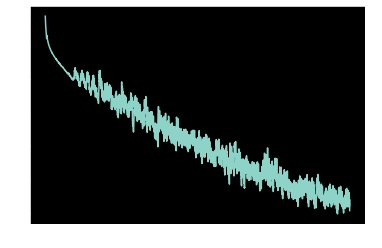

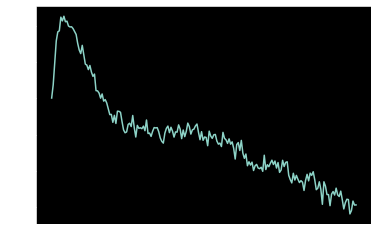

In [82]:
saved_model_dir = os.path.join("MAML", 
                               "LSwFW_model",
                               time.strftime("%Y%m%d_LSwFW_model_SimilarityBatching")
                              )
try:
    os.mkdir(saved_model_dir)
except:
    pass
LSwFW_model = train_maml(LSwFW_model,
                   epochs=200,
                   X_train=np.hstack([selected_train_features, 
                                      selected_train_Fweights]),
                   y_train=all_train_targets,
                   X_test=np.hstack([selected_test_features,
                                     selected_test_Fweights]), 
                   y_test=test_targets,
                   saved_model_dir=saved_model_dir, 
                         similarity_batching_kwargs = {"n_clusters": 10}
                   )

In [23]:
# results = []
# ds_loader = MetaLearnDSLoader(X=selected_train_features,
#                               y=all_train_targets,
#                               train_size=100,
#                               metatrain_size=100,
#                               balanced_sampling=True,
#                               shuffle=True,
#                               batch_size=8
#                               )
# for label_idx in range(test_targets.shape[1]):
#     label_name = labels[label_idx]
#     ind = np.where(~tf.math.is_nan(test_targets[:, label_idx]))[0]
#     thresh = get_p(all_train_targets[:, label_idx])
    
#     X_tasked_batched, y_tasked_batched = ds_loader.load_task(label_idx)
#     auc, f1, acc = eval_maml(model, 
#                              X_task = selected_test_features[ind, :], 
#                              y_task = test_targets[ind, label_idx], 
#                              thresh = thresh, 
#                              metatest_training = True, 
#                              X_train_batched = X_tasked_batched,
#                              y_train_batched = y_tasked_batched
#                             )
#     results.append([label_name, "AUC", auc])
#     results.append([label_name, "f1", f1])
#     results.append([label_name, "acc", acc])
    
# results_df = pd.DataFrame(results, columns = ["Label", 'metric', 'score'])

In [24]:
# results_df.query("metric == 'AUC'")

,Label,metric,score
0,NR-AR,AUC,0.826673
3,NR-AhR,AUC,0.732287
6,NR-AR-LBD,AUC,0.716132
9,NR-ER,AUC,0.754617
12,NR-ER-LBD,AUC,0.646164
15,NR-Aromatase,AUC,0.691132
18,NR-PPAR-gamma,AUC,0.692126
21,SR-ARE,AUC,0.679983
24,SR-ATAD5,AUC,0.730997
27,SR-HSE,AUC,0.690824


## Try maml with attention model

In [84]:
from Tox21experiment_helper import load_data, get_dense_model, get_model_setup_params, get_model_compile_params
from tf_helpers import get_weights_dicts 

model_setup_params = get_model_setup_params()
model_setup_params['n_out']=1
model_setup_params['n_feat'] = 348
model_setup_params['n_hidden'] = 512
model_setup_params['concat_activation']=tf.nn.leaky_relu
model_setup_params['hidden_activation'] = tf.nn.leaky_relu
weights_dict = get_weights_dicts(all_train_targets)
model_compile_params_0 = get_model_compile_params(weights_dict[0], 
                                                0.001)
model_compile_params_0['metrics'] = [AveragedAUCIgnoreNan(num_labels = 1)]
LS_model = get_attention_model(**model_setup_params)
LS_model.compile(**model_compile_params_0)

In [85]:
saved_model_dir = os.path.join("MAML", 
                               "LS_model",
                               time.strftime("%Y%m%d_LS_model")
                              )
try:
    os.mkdir(saved_model_dir)
except:
    pass
LS_model = train_maml(LS_model,
                   epochs=100,
                   X_train=selected_train_features,
                   y_train=all_train_targets,
                   X_test=selected_test_features,
                   y_test=test_targets,
                   saved_model_dir=saved_model_dir, 
                      similarity_batching_kwargs={'n_clusters':5}
                   )



Fitted 20 clusters with distribution [42 31  3  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [924 133  82  10   9   7   6   5   4   3   3   3   3   2   1   1   1   1
   1   1]
Fitted 20 clusters with distribution [32 12 11  9  6  5  5  3  3  2  2  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [924 133  82  10   9   7   6   5   4   3   3   3   3   2   1   1   1   1
   1   1]
Fitted 20 clusters with distribution [33 27  9  5  3  3  3  3  2  2  1  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [924 133  82  10   9   7   6   5   4   3   3   3   3   2   1   1   1   1
   1   1]
Fitted 20 clusters with distribution [43 19  8  5  4  3  2  2  2  2  1  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [924 133  82  10   9   7   6   5   4   3   3   3   

Fitted 20 clusters with distribution [43 17  6  4  4  4  4  4  2  2  1  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [702 227  93  66  60  12   7   5   4   4   3   3   3   3   3   1   1   1
   1   1]
Fitted 20 clusters with distribution [38 13  9  6  6  5  4  3  3  2  2  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [702 227  93  66  60  12   7   5   4   4   3   3   3   3   3   1   1   1
   1   1]
Fitted 20 clusters with distribution [53 14  5  5  3  3  2  2  2  1  1  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [702 227  93  66  60  12   7   5   4   4   3   3   3   3   3   1   1   1
   1   1]
Fitted 20 clusters with distribution [49 12  8  5  4  3  2  2  2  2  2  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [702 227  93  66  60  12   7   5   4   4   3   3   

Fitted 20 clusters with distribution [33 18  9  8  6  5  3  3  2  2  2  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [690 216 146  48  35  19   7   7   5   5   4   4   3   3   3   1   1   1
   1   1]
Fitted 20 clusters with distribution [17 15 14 12  9  6  4  4  3  3  3  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [690 216 146  48  35  19   7   7   5   5   4   4   3   3   3   1   1   1
   1   1]
Fitted 20 clusters with distribution [41  8  6  5  5  5  4  3  3  3  3  3  3  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [690 216 146  48  35  19   7   7   5   5   4   4   3   3   3   1   1   1
   1   1]
Fitted 20 clusters with distribution [29 13 12  9  6  5  4  3  3  2  2  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [690 216 146  48  35  19   7   7   5   5   4   4   

Fitted 20 clusters with distribution [39 20  9  7  5  3  2  2  2  1  1  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [405 294 223 139  81  13   9   6   6   4   4   4   3   3   1   1   1   1
   1   1]
Fitted 20 clusters with distribution [17 12 12  9  8  7  7  7  3  3  3  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [405 294 223 139  81  13   9   6   6   4   4   4   3   3   1   1   1   1
   1   1]
Fitted 20 clusters with distribution [30 10 10  8  8  6  5  3  3  3  3  2  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [405 294 223 139  81  13   9   6   6   4   4   4   3   3   1   1   1   1
   1   1]
Fitted 20 clusters with distribution [17 14 13 11 11  6  6  4  3  3  2  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [405 294 223 139  81  13   9   6   6   4   4   4   

INFO:tensorflow:Assets written to: MAML\LS_model\20210407_LS_model\saved_best\assets


INFO:tensorflow:Assets written to: MAML\LS_model\20210407_LS_model\saved_best\assets


Epoch 10, metatest_score: 0.7643430083751183
Step 10: metatrain_loss = 0.5688351392745972, metatest_score = 0.7643430083751183, Time to run 10 steps = 138.98658442497253
Fitted 20 clusters with distribution [38 19  9  7  5  3  3  2  2  2  1  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [407 285 223 150  76  13  10   6   4   4   4   4   3   3   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [18 11 11 10  9  7  5  5  4  3  3  3  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [407 285 223 150  76  13  10   6   4   4   4   4   3   3   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [39  9  9  7  7  6  3  3  3  2  2  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [407 285 223 150  76  13  10   6   4   4   4   4   3   3   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [17 13 11 11  7  7 

INFO:tensorflow:Assets written to: MAML\LS_model\20210407_LS_model\saved_best\assets


INFO:tensorflow:Assets written to: MAML\LS_model\20210407_LS_model\saved_best\assets


Epoch 11, metatest_score: 0.7651319586416087
Fitted 20 clusters with distribution [38 19  8  7  5  3  3  3  2  2  1  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [393 291 236 135  87  15   8   5   4   4   4   4   3   3   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [24 16 10  9  6  5  5  4  3  3  3  2  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [393 291 236 135  87  15   8   5   4   4   4   4   3   3   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [38 15  8  7  6  3  3  3  3  2  2  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [393 291 236 135  87  15   8   5   4   4   4   4   3   3   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [17 13 11 11  7  7  7  6  4  3  3  2  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [393 2

INFO:tensorflow:Assets written to: MAML\LS_model\20210407_LS_model\saved_best\assets


INFO:tensorflow:Assets written to: MAML\LS_model\20210407_LS_model\saved_best\assets


Epoch 12, metatest_score: 0.7659508343852721
Fitted 20 clusters with distribution [38 19  9  7  5  3  3  2  2  2  1  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [389 295 237 140  85  15   7   5   5   4   4   3   3   2   1   1   1   1
   1   1]
Fitted 20 clusters with distribution [16 13 11 10  9  6  5  5  4  4  3  3  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [389 295 237 140  85  15   7   5   5   4   4   3   3   2   1   1   1   1
   1   1]
Fitted 20 clusters with distribution [38  9  8  8  7  6  4  3  3  2  2  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [389 295 237 140  85  15   7   5   5   4   4   3   3   2   1   1   1   1
   1   1]
Fitted 20 clusters with distribution [21 17 14  9  6  6  6  3  3  2  2  2  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [389 2

INFO:tensorflow:Assets written to: MAML\LS_model\20210407_LS_model\saved_best\assets


INFO:tensorflow:Assets written to: MAML\LS_model\20210407_LS_model\saved_best\assets


Epoch 13, metatest_score: 0.766834220140166
Fitted 20 clusters with distribution [38 19  9  7  5  3  3  2  2  2  1  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [680 257 175  19  15   8   7   6   6   4   4   4   4   3   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [17 13 11 10  9  6  5  5  4  3  3  3  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [680 257 175  19  15   8   7   6   6   4   4   4   4   3   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [39 15  7  6  5  3  3  3  3  3  2  2  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [680 257 175  19  15   8   7   6   6   4   4   4   4   3   2   2   1   1
   1   1]
Fitted 20 clusters with distribution [17 13 13 11  7  7  6  5  4  3  3  2  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [680 25

INFO:tensorflow:Assets written to: MAML\LS_model\20210407_LS_model\saved_best\assets


INFO:tensorflow:Assets written to: MAML\LS_model\20210407_LS_model\saved_best\assets


Epoch 15, metatest_score: 0.7668467874442121
Fitted 20 clusters with distribution [37 23  7  6  5  3  3  2  2  2  1  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [370 314 221 151  66  19  15   7   7   5   4   4   4   4   3   2   1   1
   1   1]
Fitted 20 clusters with distribution [16 14 11 10  9  6  5  5  4  3  3  3  2  2  2  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [370 314 221 151  66  19  15   7   7   5   4   4   4   4   3   2   1   1
   1   1]
Fitted 20 clusters with distribution [38 15  8  7  6  3  3  3  3  2  2  2  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [370 314 221 151  66  19  15   7   7   5   4   4   4   4   3   2   1   1
   1   1]
Fitted 20 clusters with distribution [17 15 11 11  7  7  6  5  4  3  3  2  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [370 3

INFO:tensorflow:Assets written to: MAML\LS_model\20210407_LS_model\saved_best\assets


INFO:tensorflow:Assets written to: MAML\LS_model\20210407_LS_model\saved_best\assets


Epoch 16, metatest_score: 0.7670177848791373
Fitted 20 clusters with distribution [36 23  7  6  5  3  3  3  2  2  1  1  1  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [344 334 270 184  15   8   7   7   5   4   4   3   3   3   2   2   2   1
   1   1]
Fitted 20 clusters with distribution [17 13 11  9  9  8  5  5  4  3  3  3  2  2  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [344 334 270 184  15   8   7   7   5   4   4   3   3   3   2   2   2   1
   1   1]
Fitted 20 clusters with distribution [38 10  9  7  6  5  3  3  3  3  2  2  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [344 334 270 184  15   8   7   7   5   4   4   3   3   3   2   2   2   1
   1   1]
Fitted 20 clusters with distribution [17 15 11 10  7  7  6  4  4  4  3  3  2  1  1  1  1  1  1  1]
attentions_metatrain shape (1200, 512)
Fitted 20 clusters with distribution [344 3

INFO:tensorflow:Assets written to: MAML\LS_model\20210407_LS_model\saved_best\assets


INFO:tensorflow:Assets written to: MAML\LS_model\20210407_LS_model\saved_best\assets


Epoch 17, metatest_score: 0.7677748854654615


ResourceExhaustedError: OOM when allocating tensor with shape[10570,30,348] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Einsum]

In [27]:
from tf_helpers import BinaryCrossEntropyIgnoreNan, AveragedAUCIgnoreNan

saved_model_dir = os.path.join("MAML", 
                               "LS_model", 
                               "20210406_LS_model", 
                               "saved_best"
                              )
LS_model = tf.keras.models.load_model(saved_model_dir, 
                                         custom_objects = {
        "BinaryCrossEntropyIgnoreNan": BinaryCrossEntropyIgnoreNan,
        "AveragedAUCIgnoreNan": AveragedAUCIgnoreNan
                                         }
                                        )

In [28]:
results = []
ds_loader = MetaLearnDSLoader(X=selected_train_features,
                              y=all_train_targets,
                              train_size=100,
                              metatrain_size=100,
                              balanced_sampling=True,
                              shuffle=True,
                              batch_size=8
                              )
for label_idx in range(test_targets.shape[1]):
    label_name = labels[label_idx]
    ind = np.where(~tf.math.is_nan(test_targets[:, label_idx]))[0]
    thresh = get_p(all_train_targets[:, label_idx])
    
    X_tasked_batched, y_tasked_batched = ds_loader.load_task(label_idx)
    auc, f1, acc = eval_maml(LS_model, 
                             X_task = selected_test_features[ind, :], 
                             y_task = test_targets[ind, label_idx], 
                             thresh = thresh, 
                             metatest_training = True, 
                             X_train_batched = X_tasked_batched,
                             y_train_batched = y_tasked_batched
                            )
    results.append([label_name, "AUC", auc])
    results.append([label_name, "f1", f1])
    results.append([label_name, "acc", acc])
    
results_df = pd.DataFrame(results, columns = ["Label", 'metric', 'score'])

In [29]:
results_df.query('metric =="AUC"')

,Label,metric,score
0,NR-AR,AUC,0.689461
3,NR-AhR,AUC,0.816025
6,NR-AR-LBD,AUC,0.729501
9,NR-ER,AUC,0.771991
12,NR-ER-LBD,AUC,0.757848
15,NR-Aromatase,AUC,0.813795
18,NR-PPAR-gamma,AUC,0.744997
21,SR-ARE,AUC,0.738827
24,SR-ATAD5,AUC,0.698832
27,SR-HSE,AUC,0.712031


In [ ]:

0	NR-AR	AUC	0.686353
3	NR-AhR	AUC	0.821394
6	NR-AR-LBD	AUC	0.724599
9	NR-ER	AUC	0.771597
12	NR-ER-LBD	AUC	0.746825
15	NR-Aromatase	AUC	0.809966
18	NR-PPAR-gamma	AUC	0.729781
21	SR-ARE	AUC	0.739985
24	SR-ATAD5	AUC	0.705376
27	SR-HSE	AUC	0.718690
30	SR-MMP	AUC	0.824597
33	SR-p53	AUC	0.824045

# Old code

In [10]:
n_feat = train_data.shape[1]
n_attention = 10 #Reduced from 20 to 10. 10 works better
n_attention_hidden=40
n_attention_out=1
n_concat_hidden=128
n_hidden1 =64
n_hidden2 = 64
momentum=0.8
learning_rate=0.001

n_batch=8

label="SynthData"

save_folder=os.path.join(time.strftime("%y%m%d_TrainingLocalitySensitivewFW",
                                       time.localtime()))
checkpoint_path = os.path.join(save_folder, 
                               "LocalitySensitivewFW_{}".format("label"),
                               )

try: 
    os.mkdir(save_folder) 
except OSError as error: 
    print(error) 
    
try:
    os.mkdir(checkpoint_path)
except OSError as error:
    print(error)

from tensorflow.keras.initializers import VarianceScaling
concat_activation="selu"
attention_hidden_activation="selu"
attention_output_activation="sigmoid"
kernel_initializer=VarianceScaling()
hidden_activation="selu"

In [11]:
from algorithms import attention_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.losses import BinaryCrossentropy

np.random.seed(0)

input_layer=Input(shape=(n_feat*2, ))

attentions_layer=attention_model.ConcatAttentionswFeatWeights(
    n_attention=n_attention,
    n_attention_hidden=n_attention_hidden,
    n_attention_out=n_attention_out,
    n_feat=n_feat,
    n_hidden=n_concat_hidden,
    activation=concat_activation, 
    kernel_initializer=kernel_initializer,
    kernel_regularizer=l2(1E-5),
    bias_regularizer=l2(1E-5),
    attention_initializer=kernel_initializer,
    attention_hidden_activation=attention_hidden_activation,
    attention_output_activation=attention_output_activation,
    batch_norm_kwargs={"trainable":False, "renorm":False},
)(input_layer)
##Removed dropout for attentions_layer because of Batch normalization
# dropout0=Dropout(0.1)(attentions_layer)
dense_layer1=Dense(n_hidden1, 
                   activation=hidden_activation, 
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5),
                  )(attentions_layer)
# dropout1=Dropout(0.1)(dense_layer1)
dense_layer2=Dense(n_hidden2,
                   activation=hidden_activation,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5)
                  )(dense_layer1)
# dropout2=Dropout(0.1)(dense_layer2)
output_layer=Dense(1, activation="sigmoid")(dense_layer2)

LSwFW_model=Model(inputs=input_layer, 
                  outputs=output_layer
                 )

weights_dicts=get_weights_dicts(np.expand_dims(train_targets,1))
loss_fn=BinaryCrossEntropyIgnoreNaN(weights_dicts=weights_dicts)

# loss_fn=tf.nn.sigmoid_cross_entropy_with_logits

LSwFW_model.compile(loss=loss_fn,
    #loss=BinaryCrossentropy(from_logits=False, 
#                                             reduction=tf.keras.losses.Reduction.AUTO,
#                                            ), 
              optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy','AUC']
             )

In [12]:
LSwFW_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1890)]            0         
_________________________________________________________________
concat_attentionsw_feat_weig (None, 128)               1598500   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,610,981
Trainable params: 1,610,469
Non-trainable params: 512
_________________________________________________________________


In [ ]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_auc',
                                                 mode='max',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

csv_filename = os.path.join(checkpoint_path,
                            "training_log.csv"
                            )
csvlogger_callback = tf.keras.callbacks.CSVLogger(filename=csv_filename, append=True)

# LSwFW_model.fit(train_tensor, 
#                 train_targets, 
#                 epochs=1,
#                 batch_size=n_batch,
#                 shuffle=True,
#                 verbose=2, 
#                )
# #Set feat weights
# # Fweights=cosa_mdl.Fweight
# sampled_Fweights=train_Fweights[np.random.choice(range(len(train_Fweights)), n_attention)]
# for i in range(n_attention):
#     weights=LSwFW_model.layers[1].attention_layers[i].get_weights()
#     weights[0]=np.reshape(sampled_Fweights[i], (1,n_feat))
#     LSwFW_model.layers[1].attention_layers[i].set_weights(weights)


n_epoch=2000


LSwFW_model.fit(train_tensor, 
                train_targets, 
                epochs=n_epoch,
                batch_size=n_batch,
                validation_data=(test_tensor, test_targets),
                shuffle=True,
                verbose=2, 
                callbacks=[csvlogger_callback,
                           cp_callback
                          ]
               )

Epoch 1/2000
1168/1168 - 50s - loss: 0.4941 - accuracy: 0.8624 - auc: 0.8104 - val_loss: 0.4789 - val_accuracy: 0.9583 - val_auc: 0.6339

Epoch 00001: val_auc improved from -inf to 0.63388, saving model to 210216_TrainingLocalitySensitivewFW\LocalitySensitivewFW_label
Epoch 2/2000
1168/1168 - 50s - loss: 0.4915 - accuracy: 0.8629 - auc: 0.8151 - val_loss: 0.4723 - val_accuracy: 0.8470 - val_auc: 0.6783

Epoch 00002: val_auc improved from 0.63388 to 0.67829, saving model to 210216_TrainingLocalitySensitivewFW\LocalitySensitivewFW_label
Epoch 3/2000
1168/1168 - 51s - loss: 0.4645 - accuracy: 0.8573 - auc: 0.8400 - val_loss: 0.4559 - val_accuracy: 0.9635 - val_auc: 0.6951

Epoch 00003: val_auc improved from 0.67829 to 0.69509, saving model to 210216_TrainingLocalitySensitivewFW\LocalitySensitivewFW_label
Epoch 4/2000
1168/1168 - 50s - loss: 0.4656 - accuracy: 0.8779 - auc: 0.8425 - val_loss: 0.4847 - val_accuracy: 0.9635 - val_auc: 0.6944

Epoch 00004: val_auc did not improve from 0.69509

In [ ]:
#How to check if attentions relate to cluster? Hclust+tanimoto?

In [ ]:
#load model
#Get attentions
#Plot dimensionality reduction of attentions? Or some cluster of attentions
#Drop neighborshoods that are negative-only? A form of sub-sampling?

In [13]:
train_id_df.shape

(10570, 5)

In [14]:
test_id_df.shape

(633, 5)

In [15]:
10570+633

11203

In [29]:
file_name=os.path.join(os.environ['HOME'],
                        "Data",
                         "Tox21",
                         "5_Processed",
                       "XY_Tox21_CDKPaDEL_processed_tanimoto.csv"
                        )
import pandas as pd
df=pd.read_csv(file_name, index_col=0)

In [30]:
import copy
FP=copy.deepcopy(df['Circular fingerprints for Molecule'])

In [31]:
df.head()

,Molecule name,Canonical_QSARr,InChI_Code_QSARr,InChI Key_QSARr,Circular fingerprints for Molecule,dist_to_000,dist_to_001,dist_to_002,dist_to_003,dist_to_004,...,dist_to_12444,dist_to_12445,dist_to_12446,dist_to_12447,dist_to_12448,dist_to_12449,dist_to_12450,dist_to_12451,dist_to_12452,dist_to_12453
0,NCGC00166114-03,OC(=O)C1=CC=CC=C1C1C2C=C(Br)C(O)=C(Br)C=2OC2C=...,InChI=1S/C20H8Br4O5/c21-11-5-9-13(7-3-1-2-4-8(...,AZXGXVQWEUFULR-UHFFFAOYSA-N,0000000000000000000000000000000000000000010000...,1.000000,0.061538,0.108108,0.105634,0.050000,...,0.134328,0.081081,0.105263,0.016129,0.088235,0.016667,0.016129,0.015385,0.068966,0.064516
1,NCGC00263563-01,CC1(O)OC(C2CC(OC3CC(OC)C(OC)C(C)O3)C(O2)C2(C)C...,"InChI=1S/C47H80O17/c1-23-18-24(2)45(9,51)61-36...",RWVUEZAROXKXRT-UHFFFAOYSA-N,0000000000000001000100001000000000000000000100...,0.061538,1.000000,0.025641,0.114286,0.070175,...,0.017857,0.063063,0.020202,0.030612,0.018182,0.031250,0.052083,0.019608,0.065041,0.019608
2,NCGC00013058-02,CN(C)C1C=CC(=CC=1)C(C1C=CC=CC=1)=C1C=CC(C=C1)=...,InChI=1S/C23H25N2/c1-24(2)21-14-10-19(11-15-21...,VFCNQNZNPKRXIT-UHFFFAOYSA-N,0000000000000000000000000000000000010000000000...,0.108108,0.025641,1.000000,0.069231,0.081967,...,0.160000,0.068966,0.097561,0.000000,0.098039,0.023810,0.000000,0.043478,0.086957,0.043478
3,NCGC00167516-01,CC(C)CC(NC(=O)C(CC1=CNC2C=CC=CC=21)NC(=O)C(CC1...,InChI=1S/C64H83N17O12/c1-4-68-62(92)53-16-10-2...,GJKXGJCSJWBJEZ-UHFFFAOYSA-N,0010001100000000000000000000001000010100000000...,0.105634,0.114286,0.069231,1.000000,0.101562,...,0.081301,0.078740,0.052632,0.052632,0.100840,0.035088,0.061947,0.051282,0.094891,0.033613
4,NCGC00018301-05,CC(C)SC1=CC=C(C=C1)C(O)C(C)NCCCCCCCC,InChI=1S/C20H35NOS/c1-5-6-7-8-9-10-15-21-17(4)...,BFCDFTHTSVTWOG-UHFFFAOYSA-N,0000010000000000000000000000001000000000000000...,0.050000,0.070175,0.081967,0.101562,1.000000,...,0.090909,0.066667,0.119048,0.093023,0.115385,0.071429,0.068182,0.041667,0.069444,0.063830


In [34]:
Dmat=df.iloc[:train_id_df.shape[0],5:5+train_id_df.shape[0]]


In [105]:
to_split=range(len(Dmat))

from sklearn.cluster import AgglomerativeClustering
clust=AgglomerativeClustering(n_clusters=20, 
                              affinity="precomputed", 
                              linkage='average'
                             )
clust.fit(1-Dmat.values[np.ix_(to_split, to_split)])

AgglomerativeClustering(affinity='precomputed', linkage='average',
                        n_clusters=20)

In [106]:
drop_inds=[]
clusters=[]
new_to_split=[]
for i in range(20):
    ind=np.where(clust.labels_==i)[0]
    ind=np.array(to_split)[ind]
    arr=y_train.values[ind,0]
    if len(np.unique(arr[~np.isnan(arr)], return_counts=True)[1])==1:
        drop_inds.extend(ind)
    elif len(ind)<101 and len(ind)>20:
        clusters.append(ind)
    else:
        new_to_split.extend(ind)
to_split=copy.deepcopy(new_to_split)
new_to_split=[]

In [107]:
n_clusters=20
clust2=AgglomerativeClustering(n_clusters,
                               affinity="precomputed",
                               linkage='average'
                              )
clust2.fit(1-Dmat.values[np.ix_(to_split, to_split)])

AgglomerativeClustering(affinity='precomputed', linkage='average',
                        n_clusters=20)

In [108]:
for i in range(len(np.unique(clust2.labels_))):
    ind=np.where(clust2.labels_==i)[0]
    ind=np.array(to_split)[ind]    
    arr=y_train.values[ind,0]
    if len(np.unique(arr[~np.isnan(arr)], return_counts=True)[1])==1:
        drop_inds.extend(ind)
    elif len(ind)<101 and len(ind)>20:
        clusters.append(ind)
    else:
        new_to_split.extend(ind)
to_split=copy.deepcopy(new_to_split)
new_to_split=[]        

In [109]:
n_clusters=20
clust3=AgglomerativeClustering(n_clusters,
                               affinity="precomputed",
                               linkage='average'
                              )
clust3.fit(1-Dmat.values[np.ix_(to_split, to_split)])

for i in range(len(np.unique(clust3.labels_))):
    ind=np.where(clust3.labels_==i)[0]
    arr=y_train.values[ind,0]
    if len(np.unique(arr[~np.isnan(arr)], return_counts=True)[1])==1:
        drop_inds.extend(ind)
    elif len(ind)<101 and len(ind)>20:
        clusters.append(ind)
    else:
        new_to_split.extend(ind)
to_split=copy.deepcopy(new_to_split)
new_to_split=[]        

In [110]:
n_clusters=20
clust4=AgglomerativeClustering(n_clusters,
                               affinity="precomputed",
                               linkage='average'
                              )
clust4.fit(1-Dmat.values[np.ix_(to_split, to_split)])

for i in range(len(np.unique(clust4.labels_))):
    ind=np.where(clust4.labels_==i)[0]
    arr=y_train.values[ind,0]
    if len(np.unique(arr[~np.isnan(arr)], return_counts=True)[1])==1:
        drop_inds.extend(ind)
    elif len(ind)<101 and len(ind)>20:
        clusters.append(ind)
    else:
        new_to_split.extend(ind)
to_split=copy.deepcopy(new_to_split)
new_to_split=[]        

In [111]:
n_clusters=20
clust4=AgglomerativeClustering(n_clusters,
                               affinity="precomputed",
                               linkage='average'
                              )
clust4.fit(1-Dmat.values[np.ix_(to_split, to_split)])

for i in range(len(np.unique(clust4.labels_))):
    ind=np.where(clust4.labels_==i)[0]
    arr=y_train.values[ind,0]
    if len(np.unique(arr[~np.isnan(arr)], return_counts=True)[1])==1:
        drop_inds.extend(ind)
    elif len(ind)<101 and len(ind)>20:
        clusters.append(ind)
    else:
        new_to_split.extend(ind)
to_split=copy.deepcopy(new_to_split)
new_to_split=[]        

In [112]:
len(to_split)

8293

In [113]:
len(clusters)

16

In [ ]:
#Consider using hierarchical clustering+Tanimoto similarity to subset the dataset